<a href="https://colab.research.google.com/github/ASHIKAMOHAN/GalaxyProject/blob/main/GalaxyDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to load datasets
def load_data():
    happy_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_D.txt'
    ]
    teddy_files = [
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_D.txt'
    ]

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs




In [4]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Print number of galaxies in each dataset
print("Number of galaxies in Happy datasets:")
for i, df in enumerate(happy_dfs):
    print(f"Happy Set {chr(65+i)}: {len(df)}")

print("Number of galaxies in Teddy datasets:")
for i, df in enumerate(teddy_dfs):
    print(f"Teddy Set {chr(65+i)}: {len(df)}")

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

Number of galaxies in Happy datasets:
Happy Set A: 74950
Happy Set B: 74900
Happy Set C: 60315
Happy Set D: 74642
Number of galaxies in Teddy datasets:
Teddy Set A: 74309
Teddy Set B: 74557
Teddy Set C: 97980
Teddy Set D: 75924


In [5]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



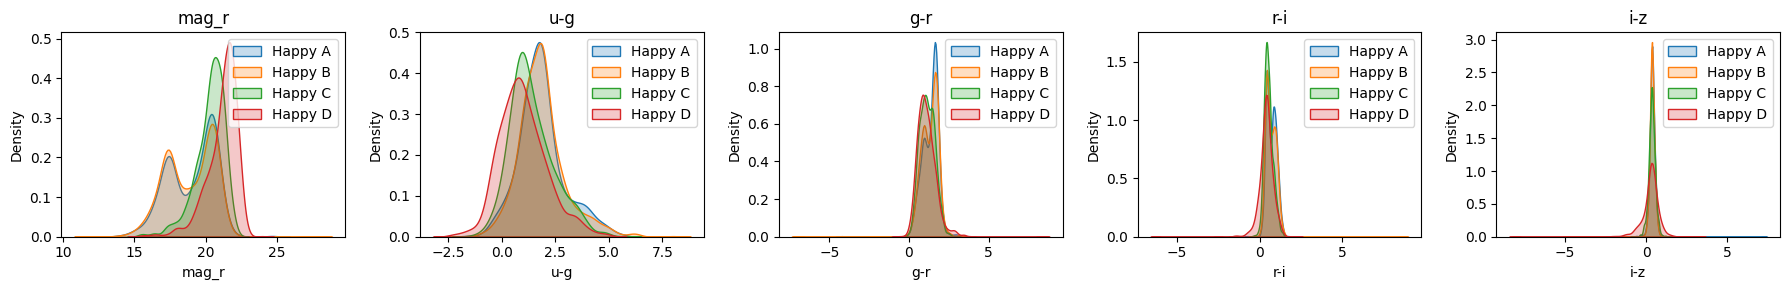

In [6]:
# Convert columns to numeric
def convert_to_numeric(dfs):
    for df in dfs:
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return dfs

# Convert the dataframes to numeric
happy_dfs = convert_to_numeric(happy_dfs)
teddy_dfs = convert_to_numeric(teddy_dfs)

# Function to sample data for faster plotting
def sample_data(dfs, sample_size=1000):
    sampled_dfs = [df.sample(n=min(sample_size, len(df)), random_state=42) for df in dfs]
    return sampled_dfs

# Sample the data
happy_dfs_sampled = sample_data(happy_dfs)
teddy_dfs_sampled = sample_data(teddy_dfs)

# Function to plot histograms and KDE
def plot_histograms_and_kde(dfs, labels, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(18, 3))
    for col, ax in zip(columns, axes):
        for df, label in zip(dfs, labels):
            sns.kdeplot(df[col], fill=True, label=label, ax=ax)
        ax.set_title(f'{col}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions for Happy datasets
columns_to_plot = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']
happy_labels = ['Happy A', 'Happy B', 'Happy C', 'Happy D']

plot_histograms_and_kde(happy_dfs_sampled, happy_labels, columns_to_plot)

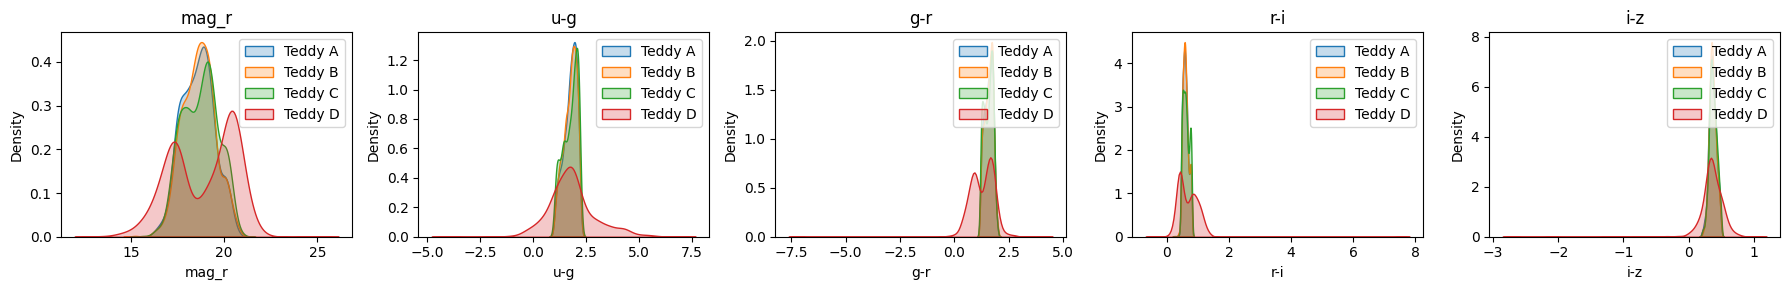

In [7]:
# Plot distributions for Teddy datasets
teddy_labels = ['Teddy A', 'Teddy B', 'Teddy C', 'Teddy D']

plot_histograms_and_kde(teddy_dfs_sampled, teddy_labels, columns_to_plot)

In [8]:
# Preprocess data
def preprocess_data(df):
    X = df[['feat1', 'feat2', 'feat3', 'feat4', 'feat5']].astype(float)
    y = df['z_spec'].astype(float)
    return X, y

# Preprocess the datasets
def preprocess_datasets(dfs):
    X_train, y_train = preprocess_data(dfs[0])
    X_val, y_val = preprocess_data(dfs[1])
    X_test_b, y_test_b = preprocess_data(dfs[1])
    X_test_c, y_test_c = preprocess_data(dfs[2])
    X_test_d, y_test_d = preprocess_data(dfs[3])
    return X_train, y_train, X_val, y_val, X_test_b, y_test_b, X_test_c, y_test_c, X_test_d, y_test_d

# Happy datasets
X_train_happy, y_train_happy, X_val_happy, y_val_happy, X_test_happy_b,y_test_happy_b, X_test_happy_c, y_test_happy_c, X_test_happy_d, y_test_happy_d = preprocess_datasets(happy_dfs)

# Teddy datasets
X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, X_test_teddy_b,y_test_teddy_b, X_test_teddy_c, y_test_teddy_c, X_test_teddy_d, y_test_teddy_d = preprocess_datasets(teddy_dfs)

def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train_happy = handle_nan(X_train_happy)
X_val_happy = handle_nan(X_val_happy)
X_test_happy_b = handle_nan(X_test_happy_b)
X_test_happy_c = handle_nan(X_test_happy_c)
X_test_happy_d = handle_nan(X_test_happy_d)
y_train_happy = handle_nan(y_train_happy)
y_val_happy = handle_nan(y_val_happy)
y_test_happy_b = handle_nan(y_test_happy_b)
y_test_happy_c = handle_nan(y_test_happy_c)
y_test_happy_d = handle_nan(y_test_happy_d)

X_train_teddy = handle_nan(X_train_teddy)
X_val_teddy = handle_nan(X_val_teddy)
X_test_teddy_b = handle_nan(X_test_teddy_b)
X_test_teddy_c = handle_nan(X_test_teddy_c)
X_test_teddy_d = handle_nan(X_test_teddy_d)
y_train_teddy = handle_nan(y_train_teddy)
y_val_teddy = handle_nan(y_val_teddy)
y_test_teddy_b = handle_nan(y_test_teddy_b)
y_test_teddy_c = handle_nan(y_test_teddy_c)
y_test_teddy_d = handle_nan(y_test_teddy_d)

# Verify no NaN values are present
def verify_no_nan(df, name):
    if df.isnull().values.any():
        print(f"NaN values found in {name}")
    else:
        print(f"No NaN values in {name}")

# Verify all datasets
verify_no_nan(X_train_happy, 'X_train_happy')
verify_no_nan(X_val_happy, 'X_val_happy')
verify_no_nan(X_test_happy_b, 'X_test_happy_b')
verify_no_nan(X_test_happy_c, 'X_test_happy_c')
verify_no_nan(X_test_happy_d, 'X_test_happy_d')
verify_no_nan(y_train_happy, 'y_train_happy')
verify_no_nan(y_val_happy, 'y_val_happy')
verify_no_nan(y_test_happy_b, 'y_test_happy_b')
verify_no_nan(y_test_happy_c, 'y_test_happy_c')
verify_no_nan(y_test_happy_d, 'y_test_happy_d')

verify_no_nan(X_train_teddy, 'X_train_teddy')
verify_no_nan(X_val_teddy, 'X_val_teddy')
verify_no_nan(X_test_teddy_b, 'X_test_teddy_b')
verify_no_nan(X_test_teddy_c, 'X_test_teddy_c')
verify_no_nan(X_test_teddy_d, 'X_test_teddy_d')
verify_no_nan(y_train_teddy, 'y_train_teddy')
verify_no_nan(y_val_teddy, 'y_val_teddy')
verify_no_nan(y_test_teddy_b, 'y_test_teddy_b')
verify_no_nan(y_test_teddy_c, 'y_test_teddy_c')
verify_no_nan(y_test_teddy_d, 'y_test_teddy_d')


No NaN values in X_train_happy
No NaN values in X_val_happy
No NaN values in X_test_happy_b
No NaN values in X_test_happy_c
No NaN values in X_test_happy_d
No NaN values in y_train_happy
No NaN values in y_val_happy
No NaN values in y_test_happy_b
No NaN values in y_test_happy_c
No NaN values in y_test_happy_d
No NaN values in X_train_teddy
No NaN values in X_val_teddy
No NaN values in X_test_teddy_b
No NaN values in X_test_teddy_c
No NaN values in X_test_teddy_d
No NaN values in y_train_teddy
No NaN values in y_val_teddy
No NaN values in y_test_teddy_b
No NaN values in y_test_teddy_c
No NaN values in y_test_teddy_d


In [9]:
# Load weights
def load_weights():
    weight_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_D.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()



In [10]:
# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d,
                   X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d):
    len_val_happy = len(X_val_happy)
    len_test_happy_b = len(X_test_happy_b)
    len_test_happy_c = len(X_test_happy_c)
    len_test_happy_d = len(X_test_happy_d)
    len_val_teddy = len(X_val_teddy)
    len_test_teddy_b = len(X_test_teddy_b)
    len_test_teddy_c = len(X_test_teddy_c)
    len_test_teddy_d = len(X_test_teddy_d)

    weights_val_happy = weights[0][:len_val_happy]
    weights_test_happy_b = weights[0][:len_test_happy_b]
    weights_test_happy_c = weights[1][:len_test_happy_c]
    weights_test_happy_d = weights[2][:len_test_happy_d]
    weights_val_teddy = weights[3][:len_val_teddy]
    weights_test_teddy_b = weights[3][:len_test_teddy_b]
    weights_test_teddy_c = weights[4][:len_test_teddy_c]
    weights_test_teddy_d = weights[5][:len_test_teddy_d]

    # Adjust weights to match lengths
    if len(weights_val_happy) < len_val_happy:
        weights_val_happy = np.concatenate([weights_val_happy, np.ones(len_val_happy - len(weights_val_happy))])
    if len(weights_test_happy_b) < len_test_happy_b:
        weights_test_happy_b = np.concatenate([weights_test_happy_b, np.ones(len_test_happy_b - len(weights_test_happy_b))])
    if len(weights_test_happy_c) < len_test_happy_c:
        weights_test_happy_c = np.concatenate([weights_test_happy_c, np.ones(len_test_happy_c - len(weights_test_happy_c))])
    if len(weights_test_happy_d) < len_test_happy_d:
        weights_test_happy_d = np.concatenate([weights_test_happy_d, np.ones(len_test_happy_d - len(weights_test_happy_d))])

    if len(weights_val_teddy) < len_val_teddy:
        weights_val_teddy = np.concatenate([weights_val_teddy, np.ones(len_val_teddy - len(weights_val_teddy))])
    if len(weights_test_teddy_b) < len_test_teddy_b:
        weights_test_teddy_b = np.concatenate([weights_test_teddy_b, np.ones(len_test_teddy_b - len(weights_test_teddy_b))])
    if len(weights_test_teddy_c) < len_test_teddy_c:
        weights_test_teddy_c = np.concatenate([weights_test_teddy_c, np.ones(len_test_teddy_c - len(weights_test_teddy_c))])
    if len(weights_test_teddy_d) < len_test_teddy_d:
        weights_test_teddy_d = np.concatenate([weights_test_teddy_d, np.ones(len_test_teddy_d - len(weights_test_teddy_d))])

    return weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c, weights_test_teddy_d

# Adjust weights lengths to match validation and test sets
weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c, weights_test_teddy_d = adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d, X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d)

print('Length of X_train_happy:', len(X_train_happy))
print('Length of y_train_happy:', len(y_train_happy))
print('Length of X_val_happy:', len(X_val_happy))
print('Length of y_val_happy:', len(y_val_happy))
print('Length of weights_val_happy:', len(weights_val_happy))
print('Length of X_test_happy_b:', len(X_test_happy_b))
print('Length of y_test_happy_b:', len(y_test_happy_b))
print('Length of weights_test_happy_b:', len(weights_test_happy_b))
print('Length of X_test_happy_c:', len(X_test_happy_c))
print('Length of y_test_happy_c:', len(y_test_happy_c))
print('Length of weights_test_happy_c:', len(weights_test_happy_c))
print('Length of X_test_happy_d:', len(X_test_happy_d))
print('Length of y_test_happy_d:', len(y_test_happy_d))
print('Length of weights_test_happy_d:', len(weights_test_happy_d))

print('Length of X_train_teddy:', len(X_train_teddy))
print('Length of y_train_teddy:', len(y_train_teddy))
print('Length of X_val_teddy:', len(X_val_teddy))
print('Length of y_val_teddy:', len(y_val_teddy))
print('Length of weights_val_teddy:', len(weights_val_teddy))
print('Length of X_test_teddy_b:', len(X_test_teddy_b))
print('Length of y_test_teddy_b:', len(y_test_teddy_b))
print('Length of weights_test_teddy_b:', len(weights_test_teddy_b))
print('Length of X_test_teddy_c:', len(X_test_teddy_c))
print('Length of y_test_teddy_c:', len(y_test_teddy_c))
print('Length of weights_test_teddy_c:', len(weights_test_teddy_c))
print('Length of X_test_teddy_d:', len(X_test_teddy_d))
print('Length of y_test_teddy_d:', len(y_test_teddy_d))
print('Length of weights_test_teddy_d:', len(weights_test_teddy_d))

Length of X_train_happy: 74950
Length of y_train_happy: 74950
Length of X_val_happy: 74900
Length of y_val_happy: 74900
Length of weights_val_happy: 74900
Length of X_test_happy_b: 74900
Length of y_test_happy_b: 74900
Length of weights_test_happy_b: 74900
Length of X_test_happy_c: 60315
Length of y_test_happy_c: 60315
Length of weights_test_happy_c: 60315
Length of X_test_happy_d: 74642
Length of y_test_happy_d: 74642
Length of weights_test_happy_d: 74642
Length of X_train_teddy: 74309
Length of y_train_teddy: 74309
Length of X_val_teddy: 74557
Length of y_val_teddy: 74557
Length of weights_val_teddy: 74557
Length of X_test_teddy_b: 74557
Length of y_test_teddy_b: 74557
Length of weights_test_teddy_b: 74557
Length of X_test_teddy_c: 97980
Length of y_test_teddy_c: 97980
Length of weights_test_teddy_c: 97980
Length of X_test_teddy_d: 75924
Length of y_test_teddy_d: 75924
Length of weights_test_teddy_d: 75924


In [11]:
def calculate_metrics(y_true, y_pred):
    mean = np.mean(y_pred)
    std = np.std(y_pred)
    mad = np.median(np.abs(y_pred - np.median(y_pred)))
    outlier_rate = np.mean(np.abs(y_true - y_pred) > (3 * mad))
    return mean, std, mad, outlier_rate

In [12]:
def train_random_forest(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_rf = rf.predict(X_val)
    mean_rf, std_rf, mad_rf, outlier_rate_rf = calculate_metrics(y_val, y_pred_rf)
    return y_pred_rf, mean_rf, std_rf, mad_rf, outlier_rate_rf

def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
    gb = GradientBoostingRegressor()
    gb.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_gb = gb.predict(X_val)
    mean_gb, std_gb, mad_gb, outlier_rate_gb = calculate_metrics(y_val, y_pred_gb)
    return y_pred_gb, mean_gb, std_gb, mad_gb, outlier_rate_gb

def train_decision_tree(X_train, y_train, X_val, y_val,weights_train=None, weights_val=None):
    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_val)
    mean_dt, std_dt, mad_dt, outlier_rate_dt = calculate_metrics(y_val, y_pred_dt)
    return y_pred_dt, mean_dt, std_dt, mad_dt, outlier_rate_dt

def train_xgboost(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_xgb = xgb.predict(X_val)
    mean_xgb, std_xgb, mad_xgb, outlier_rate_xgb = calculate_metrics(y_val, y_pred_xgb)
    return y_pred_xgb, mean_xgb, std_xgb, mad_xgb, outlier_rate_xgb



In [13]:
weights_train_happy = np.ones(len(X_train_happy))
weights_train_teddy = np.ones(len(X_train_teddy))

In [ ]:
def train_and_store_results(X_train, y_train, X_test_b, y_test_b, X_test_c, y_test_c, X_test_d, y_test_d, weights_train, weights_test_b, weights_test_c, weights_test_d):
    results = {}


In [14]:

y_pred_dt_happy_b, mean_dt_happy_b, std_dt_happy_b, mad_dt_happy_b, outlier_rate_dt_happy_b = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b)
print(f'Decision Tree (Happy - Set B) Mean: {mean_dt_happy_b}, Std: {std_dt_happy_b}, MAD: {mad_dt_happy_b}, Outlier Rate: {outlier_rate_dt_happy_b}')
y_pred_rf_happy_b, mean_rf_happy_b, std_rf_happy_b, mad_rf_happy_b, outlier_rate_rf_happy_b = train_random_forest(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b)
print(f'Random Forest (Happy - Set B) Mean: {mean_rf_happy_b}, Std: {std_rf_happy_b}, MAD: {mad_rf_happy_b}, Outlier Rate: {outlier_rate_rf_happy_b}')
y_pred_gb_happy_b, mean_gb_happy_b, std_gb_happy_b, mad_gb_happy_b, outlier_rate_gb_happy_b = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b)
print(f'Gradient Boost (Happy - Set B) Mean: {mean_gb_happy_b}, Std: {std_gb_happy_b}, MAD: {mad_gb_happy_b}, Outlier Rate: {outlier_rate_gb_happy_b}')
y_pred_xgb_happy_b, mean_xgb_happy_b, std_xgb_happy_b, mad_xgb_happy_b, outlier_rate_xgb_happy_b = train_xgboost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b)
print(f'XGBoost (Happy - Set B) Mean: {mean_xgb_happy_b}, Std: {std_xgb_happy_b}, MAD: {mad_xgb_happy_b}, Outlier Rate: {outlier_rate_xgb_happy_b}')

Decision Tree (Happy - Set B) Mean: 0.352041807623498, Std: 0.21234291197408348, MAD: 0.19130249999999993, Outlier Rate: 0.0018558077436582109
Random Forest (Happy - Set B) Mean: 0.3516045450538843, Std: 0.20437778263898307, MAD: 0.18580600978330658, Outlier Rate: 0.0008144192256341789
Gradient Boost (Happy - Set B) Mean: 0.3517066011574216, Std: 0.20298007660092562, MAD: 0.18730865462042634, Outlier Rate: 0.0006275033377837117
XGBoost (Happy - Set B) Mean: 0.35161757469177246, Std: 0.20585519075393677, MAD: 0.18688061833381653, Outlier Rate: 0.0008544726301735648


In [15]:
y_pred_dt_teddy_b, mean_dt_teddy_b, std_dt_teddy_b, mad_dt_teddy_b, outlier_rate_dt_teddy_b = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b)
print(f'Decision Tree (Teddy - Set B) Mean: {mean_dt_teddy_b}, Std: {std_dt_teddy_b}, MAD: {mad_dt_teddy_b}, Outlier Rate: {outlier_rate_dt_teddy_b}')
y_pred_rf_teddy_b, mean_rf_teddy_b, std_rf_teddy_b, mad_rf_teddy_b, outlier_rate_rf_teddy_b = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b)
print(f'Random Forest (Teddy - Set B) Mean: {mean_rf_teddy_b}, Std: {std_rf_teddy_b}, MAD: {mad_rf_teddy_b}, Outlier Rate: {outlier_rate_rf_teddy_b}')
y_pred_gb_teddy_b, mean_gb_teddy_b, std_gb_teddy_b, mad_gb_teddy_b, outlier_rate_gb_teddy_b = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b)
print(f'Gradient Boost (Teddy - Set B) Mean: {mean_gb_teddy_b}, Std: {std_gb_teddy_b}, MAD: {mad_gb_teddy_b}, Outlier Rate: {outlier_rate_gb_teddy_b}')
y_pred_xgb_teddy_b, mean_xgb_teddy_b, std_xgb_teddy_b, mad_xgb_teddy_b, outlier_rate_xgb_teddy_b = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b)
print(f'XGBoost (Teddy - Set B) Mean: {mean_xgb_teddy_b}, Std: {std_xgb_teddy_b}, MAD: {mad_xgb_teddy_b}, Outlier Rate: {outlier_rate_xgb_teddy_b}')

Decision Tree (Teddy - Set B) Mean: 0.32302329126708423, Std: 0.0880184018339738, MAD: 0.06617499999999998, Outlier Rate: 0.006733103531526215
Random Forest (Teddy - Set B) Mean: 0.3230615226535813, Std: 0.08131903039409175, MAD: 0.06084388860836831, Outlier Rate: 0.002588623469291951
Gradient Boost (Teddy - Set B) Mean: 0.3230735219993068, Std: 0.08090626813270398, MAD: 0.05924301102697804, Outlier Rate: 0.0029373499470204006
XGBoost (Teddy - Set B) Mean: 0.32305029034614563, Std: 0.08187831193208694, MAD: 0.06121933460235596, Outlier Rate: 0.0028971122765132718


In [16]:
y_pred_dt_happy_c, mean_dt_happy_c, std_dt_happy_c, mad_dt_happy_c, outlier_rate_dt_happy_c = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c)
print(f'Decision Tree (Happy - Set C) Mean: {mean_dt_happy_c}, Std: {std_dt_happy_c}, MAD: {mad_dt_happy_c}, Outlier Rate: {outlier_rate_dt_happy_c}')
y_pred_rf_happy_c, mean_rf_happy_c, std_rf_happy_c, mad_rf_happy_c, outlier_rate_rf_happy_c = train_random_forest(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c)
print(f'Random Forest (Happy - Set C) Mean: {mean_rf_happy_c}, Std: {std_rf_happy_c}, MAD: {mad_rf_happy_c}, Outlier Rate: {outlier_rate_rf_happy_c}')
y_pred_gb_happy_c, mean_gb_happy_c, std_gb_happy_c, mad_gb_happy_c, outlier_rate_gb_happy_c = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c)
print(f'Gradient Boost (Happy - Set C) Mean: {mean_gb_happy_c}, Std: {std_gb_happy_c}, MAD: {mad_gb_happy_c}, Outlier Rate: {outlier_rate_gb_happy_c}')
y_pred_xgb_happy_c, mean_xgb_happy_c, std_xgb_happy_c, mad_xgb_happy_c, outlier_rate_xgb_happy_c = train_xgboost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c)
print(f'XGBoost (Happy - Set C) Mean: {mean_xgb_happy_c}, Std: {std_xgb_happy_c}, MAD: {mad_xgb_happy_c}, Outlier Rate: {outlier_rate_xgb_happy_c}')


Decision Tree (Happy - Set C) Mean: 0.382725366343364, Std: 0.18778038578459533, MAD: 0.137176, Outlier Rate: 0.032612119704882696
Random Forest (Happy - Set C) Mean: 0.37877422419769896, Std: 0.14779459530755118, MAD: 0.10140320480878018, Outlier Rate: 0.02176904584265937
Gradient Boost (Happy - Set C) Mean: 0.3852203423145613, Std: 0.14112215479370677, MAD: 0.08470599545658503, Outlier Rate: 0.03518196136947691
XGBoost (Happy - Set C) Mean: 0.3855495750904083, Std: 0.1577347368001938, MAD: 0.11008241772651672, Outlier Rate: 0.019083146812567356


In [17]:
y_pred_dt_teddy_c, mean_dt_teddy_c, std_dt_teddy_c, mad_dt_teddy_c, outlier_rate_dt_teddy_c = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c)
print(f'Decision Tree (Teddy - Set C) Mean: {mean_dt_teddy_c}, Std: {std_dt_teddy_c}, MAD: {mad_dt_teddy_c}, Outlier Rate: {outlier_rate_dt_teddy_c}')
y_pred_rf_teddy_c, mean_rf_teddy_c, std_rf_teddy_c, mad_rf_teddy_c, outlier_rate_rf_teddy_c = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c)
print(f'Random Forest (Teddy - Set C) Mean: {mean_rf_teddy_c}, Std: {std_rf_teddy_c}, MAD: {mad_rf_teddy_c}, Outlier Rate: {outlier_rate_rf_teddy_c}')
y_pred_gb_teddy_c, mean_gb_teddy_c, std_gb_teddy_c, mad_gb_teddy_c, outlier_rate_gb_teddy_c = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c)
print(f'Gradient Boost (Teddy - Set C) Mean: {mean_gb_teddy_c}, Std: {std_gb_teddy_c}, MAD: {mad_gb_teddy_c}, Outlier Rate: {outlier_rate_gb_teddy_c}')
y_pred_xgb_teddy_c, mean_xgb_teddy_c, std_xgb_teddy_c, mad_xgb_teddy_c, outlier_rate_xgb_teddy_c = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c)
print(f'XGBoost (Teddy - Set C) Mean: {mean_xgb_teddy_c}, Std: {std_xgb_teddy_c}, MAD: {mad_xgb_teddy_c}, Outlier Rate: {outlier_rate_xgb_teddy_c}')

Decision Tree (Teddy - Set C) Mean: 0.32883918452745453, Std: 0.09947816249117765, MAD: 0.082884, Outlier Rate: 0.004102878138395591
Random Forest (Teddy - Set C) Mean: 0.3290859980010039, Std: 0.09256924900378352, MAD: 0.08043263036730741, Outlier Rate: 0.0012043274137579097
Gradient Boost (Teddy - Set C) Mean: 0.32901074189837326, Std: 0.0921740736427594, MAD: 0.0795051148698663, Outlier Rate: 0.0010104102878138396
XGBoost (Teddy - Set C) Mean: 0.3291086256504059, Std: 0.09340249001979828, MAD: 0.08007001876831055, Outlier Rate: 0.0014186568687487241


In [18]:
y_pred_dt_happy_d, mean_dt_happy_d, std_dt_happy_d, mad_dt_happy_d, outlier_rate_dt_happy_d = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'Decision Tree (Happy - Set D) Mean: {mean_dt_happy_d}, Std: {std_dt_happy_d}, MAD: {mad_dt_happy_d}, Outlier Rate: {outlier_rate_dt_happy_d}')
y_pred_rf_happy_d, mean_rf_happy_d, std_rf_happy_d, mad_rf_happy_d, outlier_rate_rf_happy_d = train_random_forest(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'Random Forest (Happy - Set D) Mean: {mean_rf_happy_d}, Std: {std_rf_happy_d}, MAD: {mad_rf_happy_d}, Outlier Rate: {outlier_rate_rf_happy_d}')
y_pred_gb_happy_d, mean_gb_happy_d, std_gb_happy_d, mad_gb_happy_d, outlier_rate_gb_happy_d = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'Gradient Boost (Happy - Set D) Mean: {mean_gb_happy_d}, Std: {std_gb_happy_d}, MAD: {mad_gb_happy_d}, Outlier Rate: {outlier_rate_gb_happy_d}')
y_pred_xgb_happy_d, mean_xgb_happy_d, std_xgb_happy_d, mad_xgb_happy_d, outlier_rate_xgb_happy_d = train_xgboost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'XGBoost (Happy - Set D) Mean: {mean_xgb_happy_d}, Std: {std_xgb_happy_d}, MAD: {mad_xgb_happy_d}, Outlier Rate: {outlier_rate_xgb_happy_d}')

Decision Tree (Happy - Set D) Mean: 0.45758115715013004, Std: 0.2289586399304082, MAD: 0.166281, Outlier Rate: 0.05399105061493529
Random Forest (Happy - Set D) Mean: 0.44563385924487015, Std: 0.15199999323981023, MAD: 0.10159860969064935, Outlier Rate: 0.08095978135634094
Gradient Boost (Happy - Set D) Mean: 0.4437187810263585, Std: 0.15230261778901472, MAD: 0.1092493026452811, Outlier Rate: 0.06446772594517831
XGBoost (Happy - Set D) Mean: 0.45001354813575745, Std: 0.173566997051239, MAD: 0.11844973266124725, Outlier Rate: 0.06553950858765842


In [19]:
y_pred_dt_teddy_d, mean_dt_teddy_d, std_dt_teddy_d, mad_dt_teddy_d, outlier_rate_dt_teddy_d = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'Decision Tree (Teddy - Set D) Mean: {mean_dt_teddy_d}, Std: {std_dt_teddy_d}, MAD: {mad_dt_teddy_d}, Outlier Rate: {outlier_rate_dt_teddy_d}')
y_pred_rf_teddy_d, mean_rf_teddy_d, std_rf_teddy_d, mad_rf_teddy_d, outlier_rate_rf_teddy_d = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'Random Forest (Teddy - Set D) Mean: {mean_rf_teddy_d}, Std: {std_rf_teddy_d}, MAD: {mad_rf_teddy_d}, Outlier Rate: {outlier_rate_rf_teddy_d}')
y_pred_gb_teddy_d, mean_gb_teddy_d, std_gb_teddy_d, mad_gb_teddy_d, outlier_rate_gb_teddy_d = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'Gradient Boost (Teddy - Set D) Mean: {mean_gb_teddy_d}, Std: {std_gb_teddy_d}, MAD: {mad_gb_teddy_d}, Outlier Rate: {outlier_rate_gb_teddy_d}')
y_pred_xgb_teddy_d, mean_xgb_teddy_d, std_xgb_teddy_d, mad_xgb_teddy_d, outlier_rate_xgb_teddy_d = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'XGBoost (Teddy - Set D) Mean: {mean_xgb_teddy_d}, Std: {std_xgb_teddy_d}, MAD: {mad_xgb_teddy_d}, Outlier Rate: {outlier_rate_xgb_teddy_d}')


Decision Tree (Teddy - Set D) Mean: 0.34466367325219965, Std: 0.15369837021608118, MAD: 0.13764050000000003, Outlier Rate: 0.0055055055055055055
Random Forest (Teddy - Set D) Mean: 0.3496335634134677, Std: 0.13177844651489026, MAD: 0.09857712525271195, Outlier Rate: 0.010905642484589853
Gradient Boost (Teddy - Set D) Mean: 0.3439249530121117, Std: 0.13327126945937354, MAD: 0.09498619731017083, Outlier Rate: 0.0183077814656762
XGBoost (Teddy - Set D) Mean: 0.3443067967891693, Std: 0.13622388243675232, MAD: 0.1073538064956665, Outlier Rate: 0.010115378536431168


In [20]:
print('Training and evaluating models with weights…')

Training and evaluating models with weights…


In [21]:
y_pred_rf_happy_b_w, mean_rf_happy_b_w, std_rf_happy_b_w, mad_rf_happy_b_w, outlier_rate_rf_happy_b_w = train_random_forest(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'Random Forest(Happy - Set B) Weighted: Mean: {mean_rf_happy_b_w}, Std: {std_rf_happy_b_w}, MAD: {mad_rf_happy_b_w}, Outlier Rate: {outlier_rate_rf_happy_b_w}')
y_pred_gb_happy_b_w, mean_gb_happy_b_w, std_gb_happy_b_w, mad_gb_happy_b_w, outlier_rate_gb_happy_b_w = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'Gradient Boost (Happy - Set B) Weighted: Mean: {mean_gb_happy_b_w}, Std: {std_gb_happy_b_w}, MAD: {mad_gb_happy_b_w}, Outlier Rate: {outlier_rate_gb_happy_b_w}')
y_pred_xgb_happy_b_w, mean_xgb_happy_b_w, std_xgb_happy_b_w, mad_xgb_happy_b_w, outlier_rate_xgb_happy_b_w = train_xgboost(X_train_happy, y_train_happy, X_test_happy_b, y_test_happy_b, weights_train_happy, weights_test_happy_b)
print(f'XGBoost (Happy - Set B) Mean: {mean_xgb_happy_b_w}, Std: {std_xgb_happy_b_w}, MAD: {mad_xgb_happy_b_w}, Outlier Rate: {outlier_rate_xgb_happy_b_w}')

Random Forest(Happy - Set B) Weighted: Mean: 0.3516045450538843, Std: 0.20437778263898307, MAD: 0.18580600978330658, Outlier Rate: 0.0008144192256341789
Gradient Boost (Happy - Set B) Weighted: Mean: 0.3517075025566996, Std: 0.20297941468077013, MAD: 0.1873086546204264, Outlier Rate: 0.0006275033377837117
XGBoost (Happy - Set B) Mean: 0.35161757469177246, Std: 0.20585519075393677, MAD: 0.18688061833381653, Outlier Rate: 0.0008544726301735648


In [22]:
y_pred_rf_teddy_b_w, mean_rf_teddy_b_w, std_rf_teddy_b_w, mad_rf_teddy_b_w, outlier_rate_rf_teddy_b_w = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'Random Forest (Teddy - Set B) Mean: {mean_rf_teddy_b_w}, Std: {std_rf_teddy_b_w}, MAD: {mad_rf_teddy_b_w}, Outlier Rate: {outlier_rate_rf_teddy_b_w}')
y_pred_gb_teddy_b_w, mean_gb_teddy_b_w, std_gb_teddy_b_w, mad_gb_teddy_b_w, outlier_rate_gb_teddy_b_w = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'Gradient Boost (Teddy - Set B) Mean: {mean_gb_teddy_b_w}, Std: {std_gb_teddy_b_w}, MAD: {mad_gb_teddy_b_w}, Outlier Rate: {outlier_rate_gb_teddy_b_w}')
y_pred_xgb_teddy_b_w, mean_xgb_teddy_b_w, std_xgb_teddy_b_w, mad_xgb_teddy_b_w, outlier_rate_xgb_teddy_b_w = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_b, y_test_teddy_b, weights_train_teddy, weights_test_teddy_b)
print(f'XGBoost (Teddy - Set B) Mean: {mean_xgb_teddy_b_w}, Std: {std_xgb_teddy_b_w}, MAD: {mad_xgb_teddy_b_w}, Outlier Rate: {outlier_rate_xgb_teddy_b_w}')

Random Forest (Teddy - Set B) Mean: 0.3230615226535813, Std: 0.08131903039409175, MAD: 0.06084388860836831, Outlier Rate: 0.002588623469291951
Gradient Boost (Teddy - Set B) Mean: 0.32307286850280137, Std: 0.08090327102861351, MAD: 0.05924196843178109, Outlier Rate: 0.0029373499470204006
XGBoost (Teddy - Set B) Mean: 0.32305029034614563, Std: 0.08187831193208694, MAD: 0.06121933460235596, Outlier Rate: 0.0028971122765132718


In [23]:

y_pred_rf_happy_c_w, mean_rf_happy_c_w, std_rf_happy_c_w, mad_rf_happy_c_w, outlier_rate_rf_happy_c_w = train_random_forest(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'Random Forest (Happy - Set C) Mean: {mean_rf_happy_c_w}, Std: {std_rf_happy_c_w}, MAD: {mad_rf_happy_c_w}, Outlier Rate: {outlier_rate_rf_happy_c_w}')
y_pred_gb_happy_c_w, mean_gb_happy_c_w, std_gb_happy_c_w, mad_gb_happy_c_w, outlier_rate_gb_happy_c_w = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'Gradient Boost (Happy - Set C) Mean: {mean_gb_happy_c_w}, Std: {std_gb_happy_c_w}, MAD: {mad_gb_happy_c_w}, Outlier Rate: {outlier_rate_gb_happy_c_w}')
y_pred_xgb_happy_c_w, mean_xgb_happy_c_w, std_xgb_happy_c_w, mad_xgb_happy_c_w, outlier_rate_xgb_happy_c_w = train_xgboost(X_train_happy, y_train_happy, X_test_happy_c, y_test_happy_c, weights_train_happy, weights_test_happy_c)
print(f'XGBoost (Happy - Set C) Mean: {mean_xgb_happy_c_w}, Std: {std_xgb_happy_c_w}, MAD: {mad_xgb_happy_c_w}, Outlier Rate: {outlier_rate_xgb_happy_c_w}')

Random Forest (Happy - Set C) Mean: 0.37877422419769896, Std: 0.14779459530755118, MAD: 0.10140320480878018, Outlier Rate: 0.02176904584265937
Gradient Boost (Happy - Set C) Mean: 0.3852195231913647, Std: 0.1411233427773444, MAD: 0.08470599545658475, Outlier Rate: 0.03518196136947691
XGBoost (Happy - Set C) Mean: 0.3855495750904083, Std: 0.1577347368001938, MAD: 0.11008241772651672, Outlier Rate: 0.019083146812567356


In [24]:
y_pred_rf_teddy_c_w, mean_rf_teddy_c_w, std_rf_teddy_c_w, mad_rf_teddy_c_w, outlier_rate_rf_teddy_c_w = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'Random Forest (Teddy - Set C) Mean: {mean_rf_teddy_c_w}, Std: {std_rf_teddy_c_w}, MAD: {mad_rf_teddy_c_w}, Outlier Rate: {outlier_rate_rf_teddy_c_w}')
y_pred_gb_teddy_c_w, mean_gb_teddy_c_w, std_gb_teddy_c_w, mad_gb_teddy_c_w, outlier_rate_gb_teddy_c_w = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'Gradient Boost (Teddy - Set C) Mean: {mean_gb_teddy_c_w}, Std: {std_gb_teddy_c_w}, MAD: {mad_gb_teddy_c_w}, Outlier Rate: {outlier_rate_gb_teddy_c_w}')
y_pred_xgb_teddy_c_w, mean_xgb_teddy_c_w, std_xgb_teddy_c_w, mad_xgb_teddy_c_w, outlier_rate_xgb_teddy_c_w = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_c, y_test_teddy_c, weights_train_teddy, weights_test_teddy_c)
print(f'XGBoost (Teddy - Set C) Mean: {mean_xgb_teddy_c_w}, Std: {std_xgb_teddy_c_w}, MAD: {mad_xgb_teddy_c_w}, Outlier Rate: {outlier_rate_xgb_teddy_c_w}')



Random Forest (Teddy - Set C) Mean: 0.3290859980010039, Std: 0.09256924900378352, MAD: 0.08043263036730741, Outlier Rate: 0.0012043274137579097
Gradient Boost (Teddy - Set C) Mean: 0.3290098555945775, Std: 0.09217176175266954, MAD: 0.07951457827175354, Outlier Rate: 0.0010002041232904674
XGBoost (Teddy - Set C) Mean: 0.3291086256504059, Std: 0.09340249001979828, MAD: 0.08007001876831055, Outlier Rate: 0.0014186568687487241


In [25]:
y_pred_rf_happy_d_w, mean_rf_happy_d_w, std_rf_happy_d_w, mad_rf_happy_d_w, outlier_rate_rf_happy_d_w = train_random_forest(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Random Forest (Happy - Set D) Mean: {mean_rf_happy_d_w}, Std: {std_rf_happy_d_w}, MAD: {mad_rf_happy_d_w}, Outlier Rate: {outlier_rate_rf_happy_d_w}')
y_pred_gb_happy_d_w, mean_gb_happy_d_w, std_gb_happy_d_w, mad_gb_happy_d_w, outlier_rate_gb_happy_d_w = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Gradient Boost (Happy - Set D) Mean: {mean_gb_happy_d_w}, Std: {std_gb_happy_d_w}, MAD: {mad_gb_happy_d_w}, Outlier Rate: {outlier_rate_gb_happy_d_w}')
y_pred_xgb_happy_d_w, mean_xgb_happy_d_w, std_xgb_happy_d_w, mad_xgb_happy_d_w, outlier_rate_xgb_happy_d_w = train_xgboost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'XGBoost (Happy - Set D) Mean: {mean_xgb_happy_d_w}, Std: {std_xgb_happy_d_w}, MAD: {mad_xgb_happy_d_w}, Outlier Rate: {outlier_rate_xgb_happy_d_w}')

Random Forest (Happy - Set D) Mean: 0.44563385924487015, Std: 0.15199999323981023, MAD: 0.10159860969064935, Outlier Rate: 0.08095978135634094
Gradient Boost (Happy - Set D) Mean: 0.443726666666155, Std: 0.152284510746372, MAD: 0.10923884062110445, Outlier Rate: 0.06445432866214731
XGBoost (Happy - Set D) Mean: 0.45001354813575745, Std: 0.173566997051239, MAD: 0.11844973266124725, Outlier Rate: 0.06553950858765842


In [26]:
y_pred_rf_teddy_d_w, mean_rf_teddy_d_w, std_rf_teddy_d_w, mad_rf_teddy_d_w, outlier_rate_rf_teddy_d_w = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Random Forest (Teddy - Set D) Mean: {mean_rf_teddy_d_w}, Std: {std_rf_teddy_d_w}, MAD: {mad_rf_teddy_d_w}, Outlier Rate: {outlier_rate_rf_teddy_d_w}')
y_pred_gb_teddy_d_w, mean_gb_teddy_d_w, std_gb_teddy_d_w, mad_gb_teddy_d_w, outlier_rate_gb_teddy_d_w = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Gradient Boost (Teddy - Set D) Mean: {mean_gb_teddy_d_w}, Std: {std_gb_teddy_d_w}, MAD: {mad_gb_teddy_d_w}, Outlier Rate: {outlier_rate_gb_teddy_d_w}')
y_pred_xgb_teddy_d_w, mean_xgb_teddy_d_w, std_xgb_teddy_d_w, mad_xgb_teddy_d_w, outlier_rate_xgb_teddy_d_w = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'XGBoost (Teddy - Set D) Mean: {mean_xgb_teddy_d_w}, Std: {std_xgb_teddy_d_w}, MAD: {mad_xgb_teddy_d_w}, Outlier Rate: {outlier_rate_xgb_teddy_d_w}')

Random Forest (Teddy - Set D) Mean: 0.3496335634134677, Std: 0.13177844651489026, MAD: 0.09857712525271195, Outlier Rate: 0.010905642484589853
Gradient Boost (Teddy - Set D) Mean: 0.34341285922759796, Std: 0.13300859750350286, MAD: 0.09510214992228, Outlier Rate: 0.019137558611242823
XGBoost (Teddy - Set D) Mean: 0.3443067967891693, Std: 0.13622388243675232, MAD: 0.1073538064956665, Outlier Rate: 0.010115378536431168


In [27]:
from scipy.stats import gaussian_kde
def visualize_results(y_test, predictions, labels, means, stds, mads, outlier_rates):
    for y_pred, label, mean, std, mad, outlier_rate in zip(predictions, labels, means, stds, mads, outlier_rates):
        plt.figure(figsize=(7, 6))
        hb = plt.hexbin(y_test, y_pred, gridsize=300, cmap='plasma', mincnt=1,alpha=0.3)
        cb = plt.colorbar(hb)
        cb.set_label('counts')

        # Plot density contours
        x = y_test
        y = y_pred
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        plt.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')

        # Add 1:1 line
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

        plt.xlim(0, max_val)
        plt.ylim(0, max_val)

        plt.xlabel('Spec-z')
        plt.ylabel('Photo-z')
        plt.title(f'{label}\nMean: {mean:.2f}, Std: {std:.2f}, MAD: {mad:.2f}, Outlier Rate: {outlier_rate:.2f}')
        plt.tight_layout()
        plt.show()

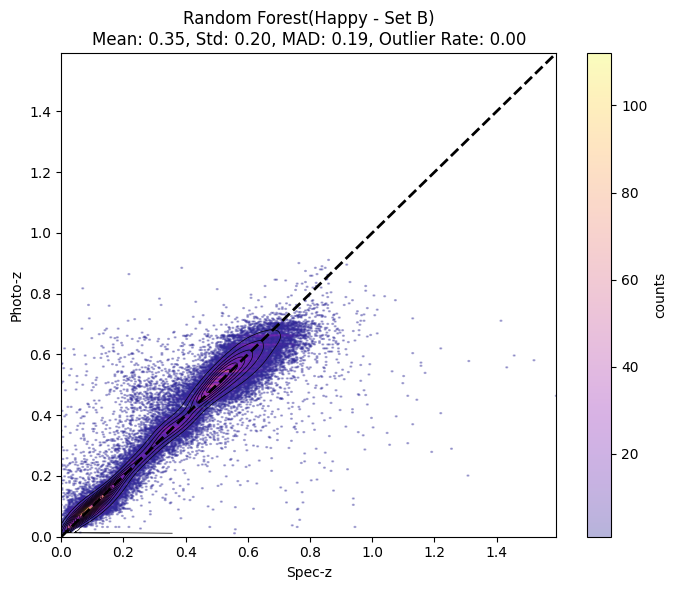

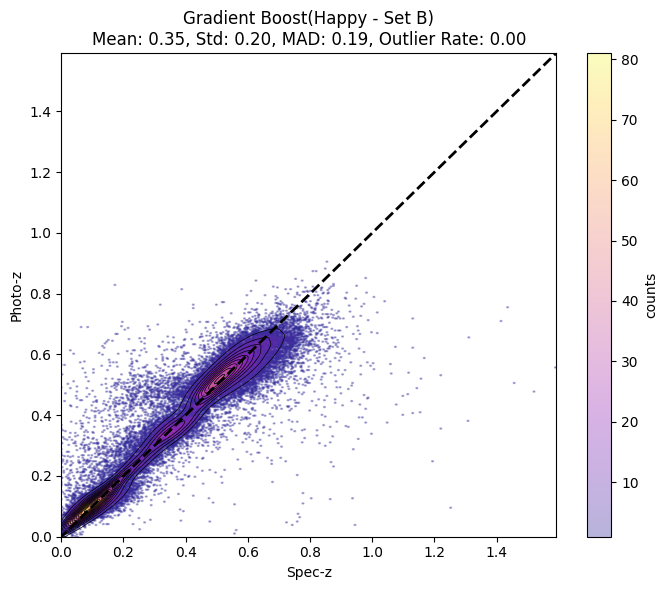

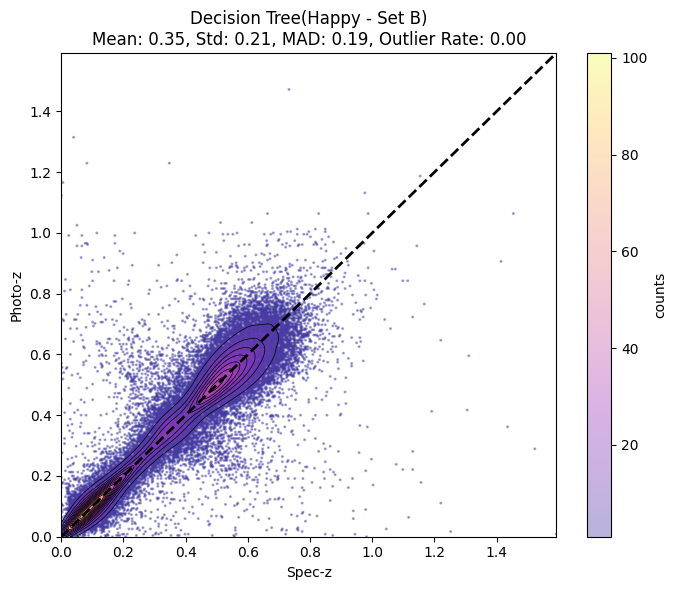

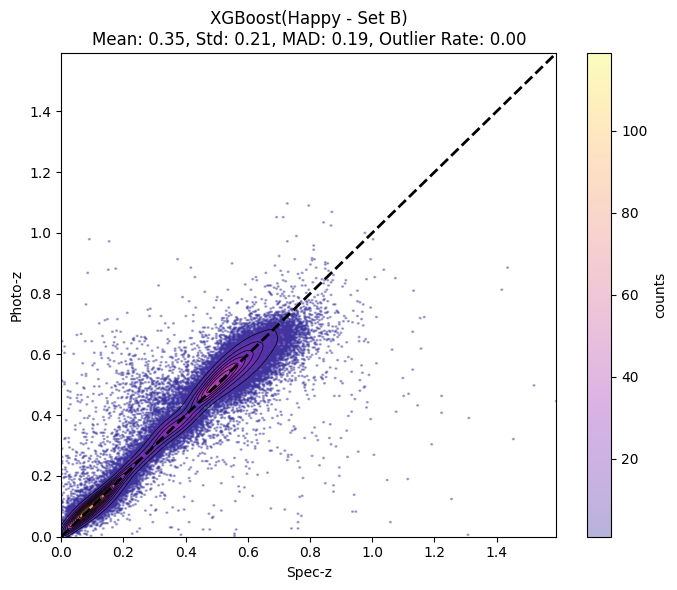

In [28]:
predictions_happy_b = [y_pred_rf_happy_b, y_pred_gb_happy_b, y_pred_dt_happy_b, y_pred_xgb_happy_b]
labels_happy_b = ['Random Forest(Happy - Set B)', 'Gradient Boost(Happy - Set B)', 'Decision Tree(Happy - Set B)', 'XGBoost(Happy - Set B)']
means_happy_b = [mean_rf_happy_b, mean_gb_happy_b, mean_dt_happy_b, mean_xgb_happy_b]
stds_happy_b = [std_rf_happy_b, std_gb_happy_b, std_dt_happy_b, std_xgb_happy_b]
mads_happy_b = [mad_rf_happy_b, mad_gb_happy_b, mad_dt_happy_b, mad_xgb_happy_b]
outlier_rates_happy_b = [outlier_rate_rf_happy_b, outlier_rate_gb_happy_b, outlier_rate_dt_happy_b, outlier_rate_xgb_happy_b]

visualize_results(y_test_happy_b, predictions_happy_b, labels_happy_b, means_happy_b, stds_happy_b, mads_happy_b, outlier_rates_happy_b)


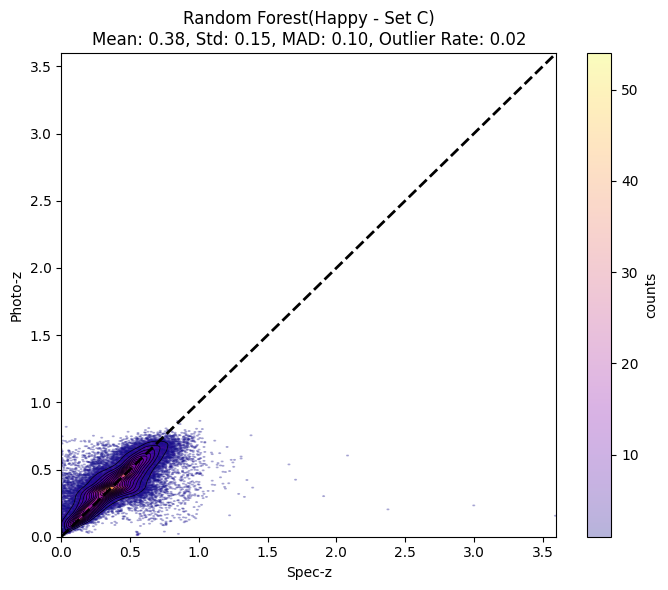

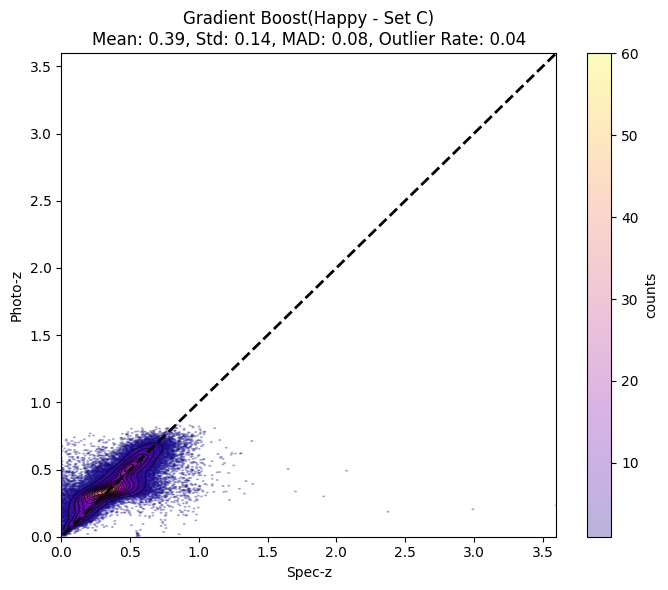

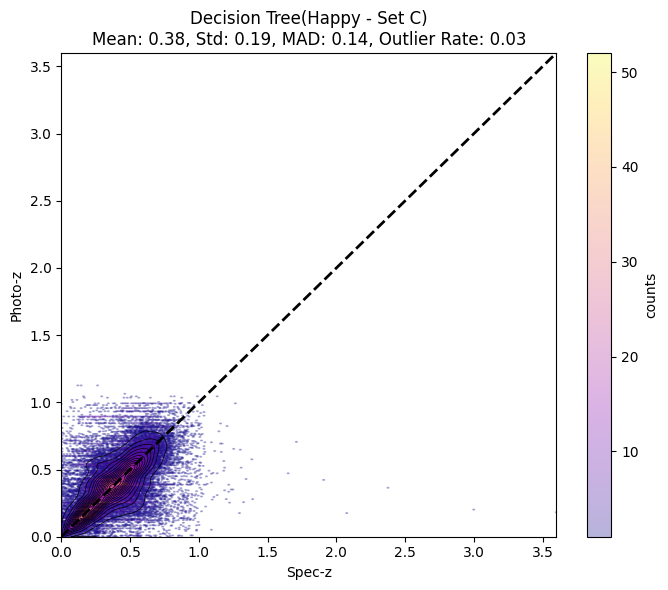

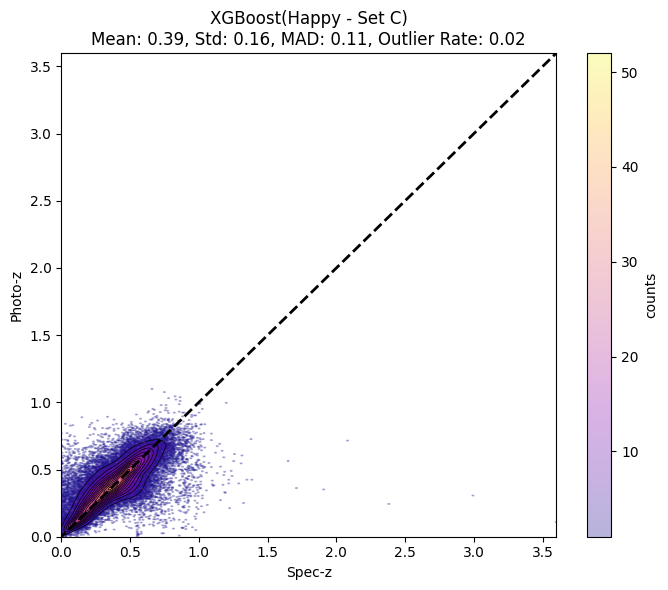

In [29]:
predictions_happy_c = [y_pred_rf_happy_c, y_pred_gb_happy_c, y_pred_dt_happy_c, y_pred_xgb_happy_c]
labels_happy_c = ['Random Forest(Happy - Set C)', 'Gradient Boost(Happy - Set C)', 'Decision Tree(Happy - Set C)', 'XGBoost(Happy - Set C)']
means_happy_c = [mean_rf_happy_c, mean_gb_happy_c, mean_dt_happy_c, mean_xgb_happy_c]
stds_happy_c = [std_rf_happy_c, std_gb_happy_c, std_dt_happy_c, std_xgb_happy_c]
mads_happy_c = [mad_rf_happy_c, mad_gb_happy_c, mad_dt_happy_c, mad_xgb_happy_c]
outlier_rates_happy_c = [outlier_rate_rf_happy_c, outlier_rate_gb_happy_c, outlier_rate_dt_happy_c, outlier_rate_xgb_happy_c]

visualize_results(y_test_happy_c, predictions_happy_c, labels_happy_c, means_happy_c, stds_happy_c, mads_happy_c, outlier_rates_happy_c)

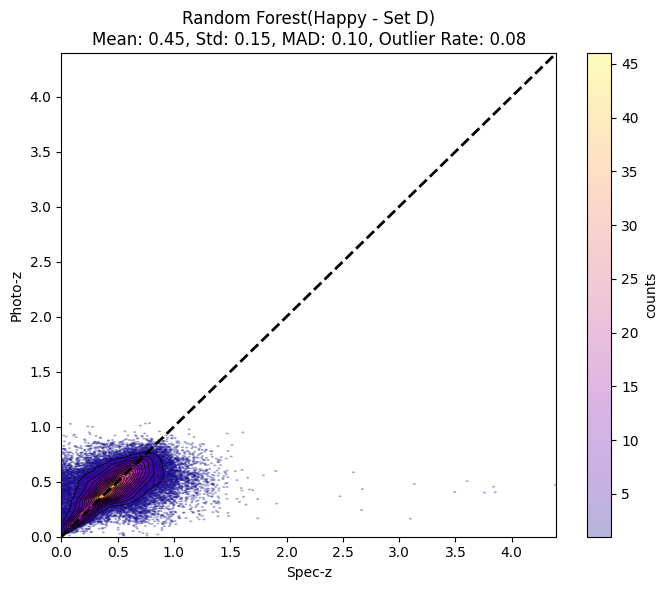

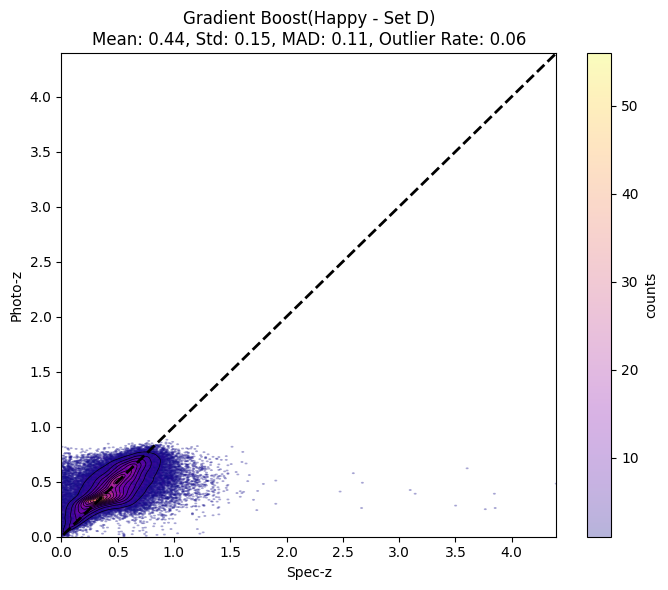

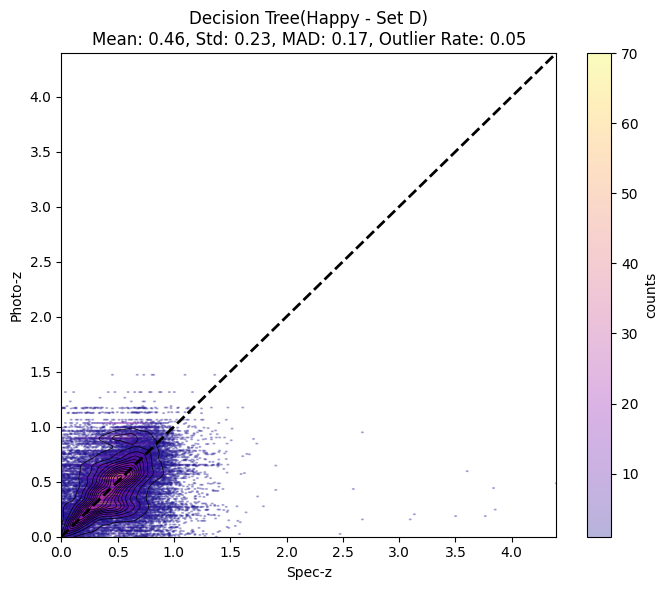

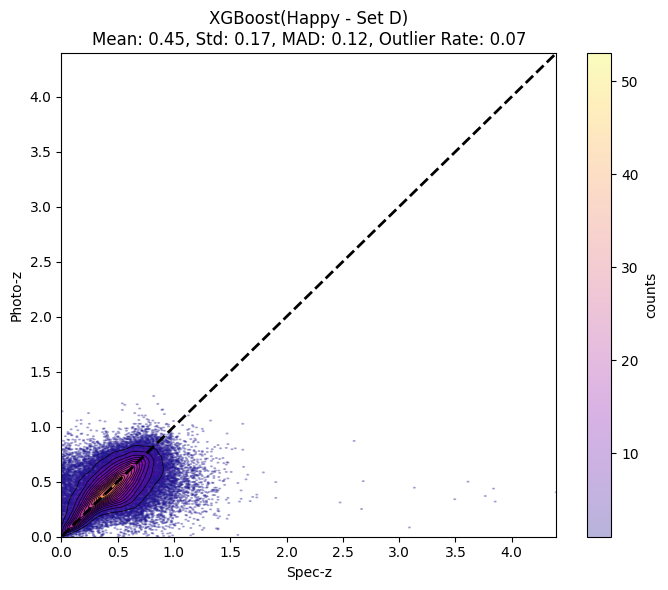

In [30]:
predictions_happy_d = [y_pred_rf_happy_d, y_pred_gb_happy_d, y_pred_dt_happy_d, y_pred_xgb_happy_d]
labels_happy_d = ['Random Forest(Happy - Set D)', 'Gradient Boost(Happy - Set D)', 'Decision Tree(Happy - Set D)', 'XGBoost(Happy - Set D)']
means_happy_d = [mean_rf_happy_d, mean_gb_happy_d, mean_dt_happy_d, mean_xgb_happy_d]
stds_happy_d = [std_rf_happy_d, std_gb_happy_d, std_dt_happy_d, std_xgb_happy_d]
mads_happy_d = [mad_rf_happy_d, mad_gb_happy_d, mad_dt_happy_d, mad_xgb_happy_d]
outlier_rates_happy_d = [outlier_rate_rf_happy_d, outlier_rate_gb_happy_d, outlier_rate_dt_happy_d, outlier_rate_xgb_happy_d]

visualize_results(y_test_happy_d, predictions_happy_d, labels_happy_d, means_happy_d, stds_happy_d, mads_happy_d, outlier_rates_happy_d)


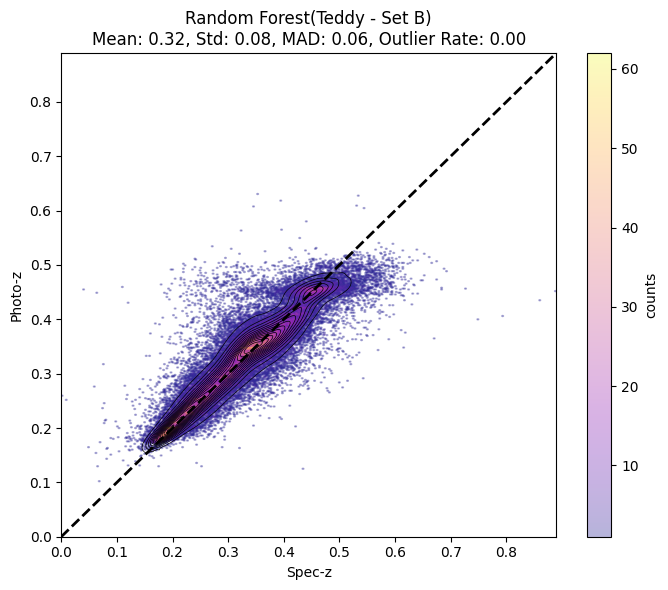

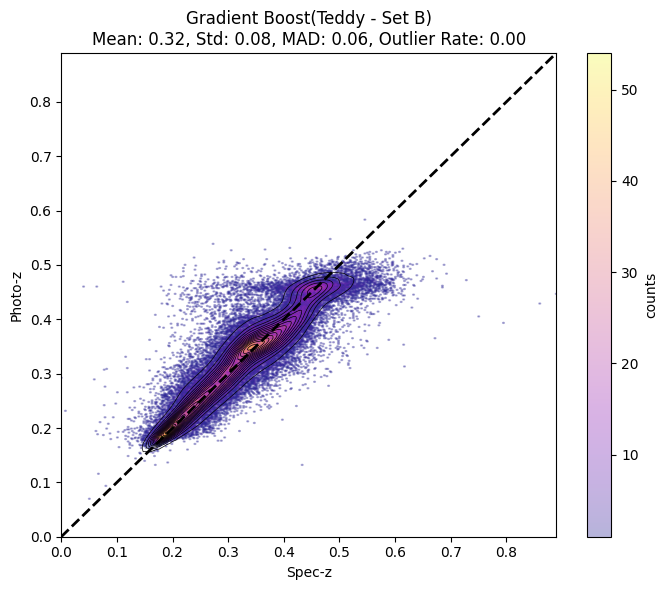

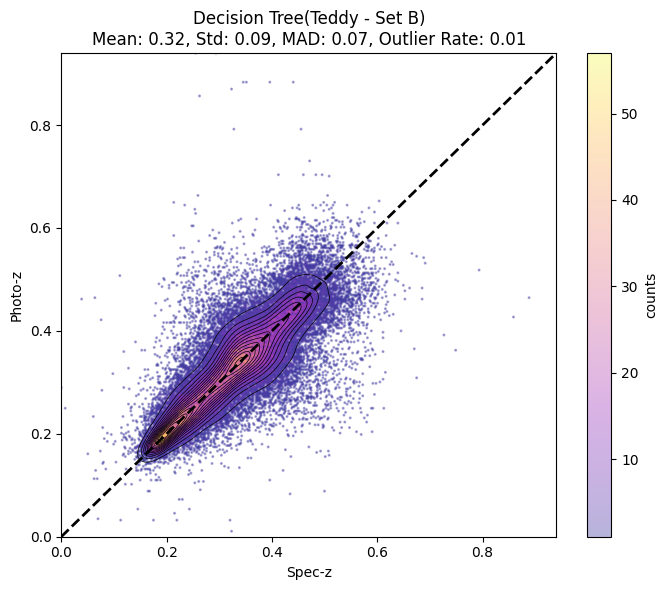

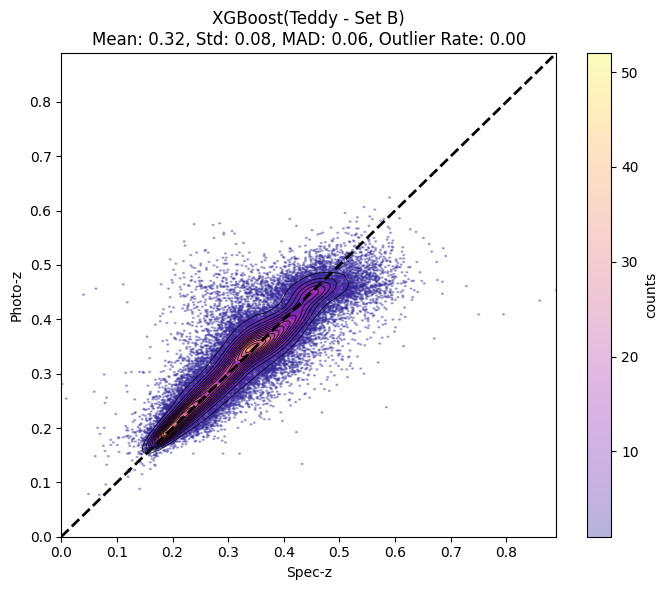

In [31]:
predictions_teddy_b = [y_pred_rf_teddy_b, y_pred_gb_teddy_b, y_pred_dt_teddy_b, y_pred_xgb_teddy_b]
labels_teddy_b = ['Random Forest(Teddy - Set B)', 'Gradient Boost(Teddy - Set B)', 'Decision Tree(Teddy - Set B)', 'XGBoost(Teddy - Set B)']
means_teddy_b = [mean_rf_teddy_b, mean_gb_teddy_b, mean_dt_teddy_b, mean_xgb_teddy_b]
stds_teddy_b = [std_rf_teddy_b, std_gb_teddy_b, std_dt_teddy_b, std_xgb_teddy_b]
mads_teddy_b = [mad_rf_teddy_b, mad_gb_teddy_b, mad_dt_teddy_b, mad_xgb_teddy_b]
outlier_rates_teddy_b = [outlier_rate_rf_teddy_b, outlier_rate_gb_teddy_b, outlier_rate_dt_teddy_b, outlier_rate_xgb_teddy_b]

visualize_results(y_test_teddy_b, predictions_teddy_b, labels_teddy_b, means_teddy_b, stds_teddy_b, mads_teddy_b, outlier_rates_teddy_b)

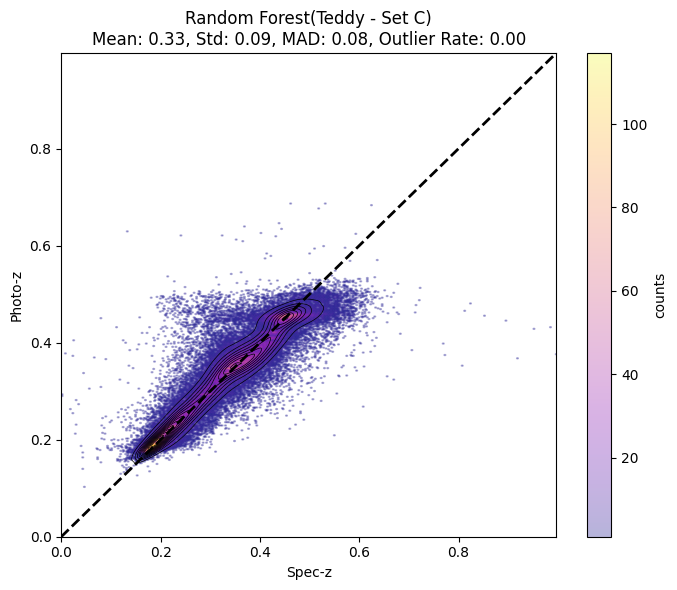

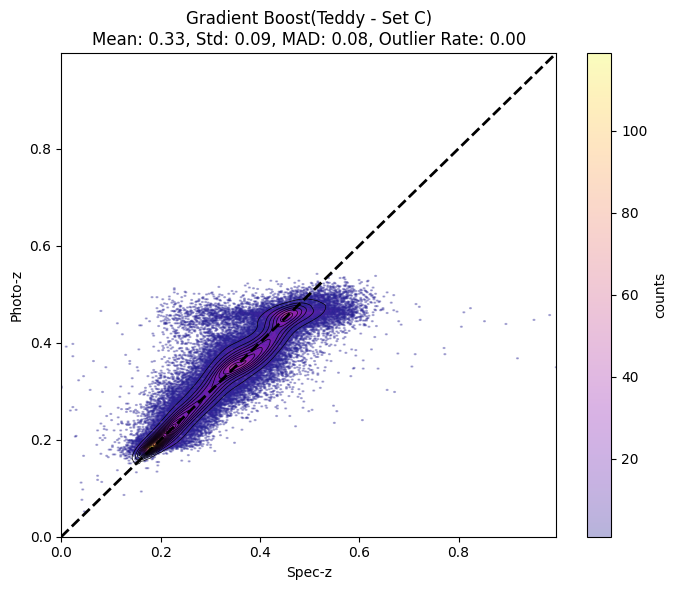

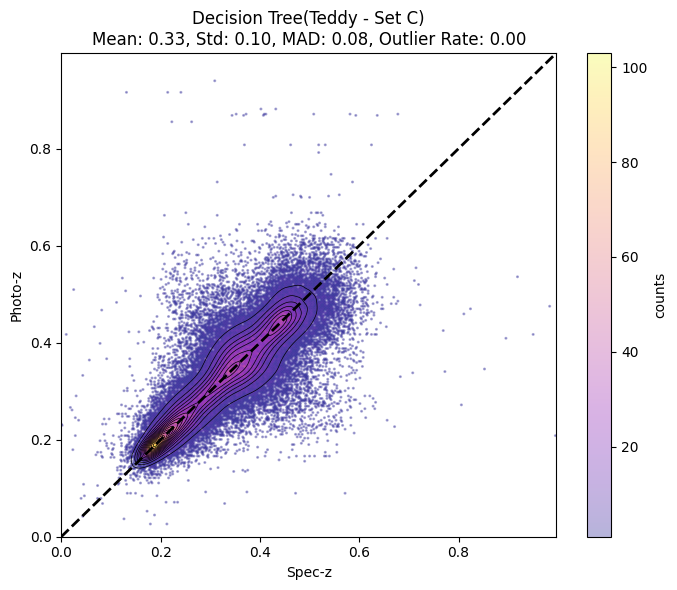

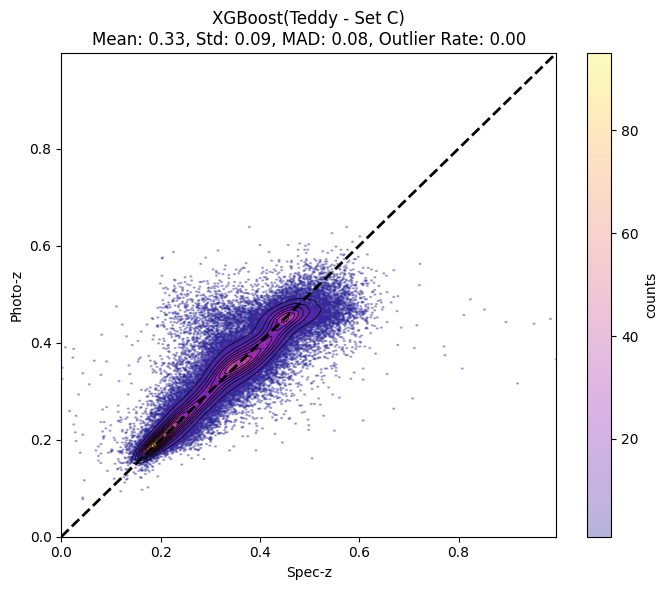

In [32]:
predictions_teddy_c = [y_pred_rf_teddy_c, y_pred_gb_teddy_c, y_pred_dt_teddy_c, y_pred_xgb_teddy_c]
labels_teddy_c = ['Random Forest(Teddy - Set C)', 'Gradient Boost(Teddy - Set C)', 'Decision Tree(Teddy - Set C)', 'XGBoost(Teddy - Set C)']
means_teddy_c = [mean_rf_teddy_c, mean_gb_teddy_c, mean_dt_teddy_c, mean_xgb_teddy_c]
stds_teddy_c = [std_rf_teddy_c, std_gb_teddy_c, std_dt_teddy_c, std_xgb_teddy_c]
mads_teddy_c = [mad_rf_teddy_c, mad_gb_teddy_c, mad_dt_teddy_c, mad_xgb_teddy_c]
outlier_rates_teddy_c = [outlier_rate_rf_teddy_c, outlier_rate_gb_teddy_c, outlier_rate_dt_teddy_c, outlier_rate_xgb_teddy_c]

visualize_results(y_test_teddy_c, predictions_teddy_c, labels_teddy_c, means_teddy_c, stds_teddy_c, mads_teddy_c, outlier_rates_teddy_c)

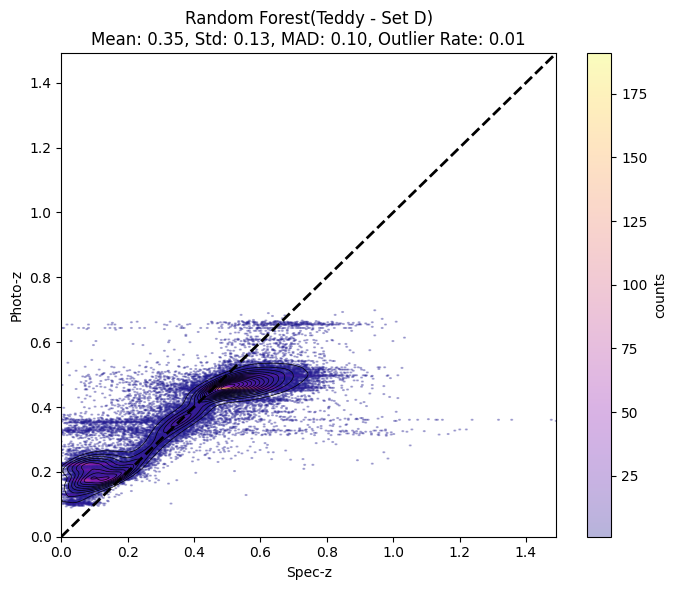

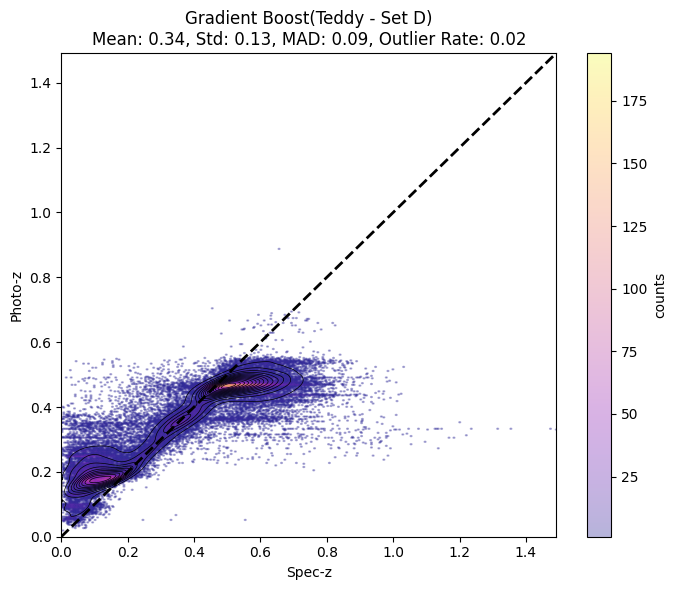

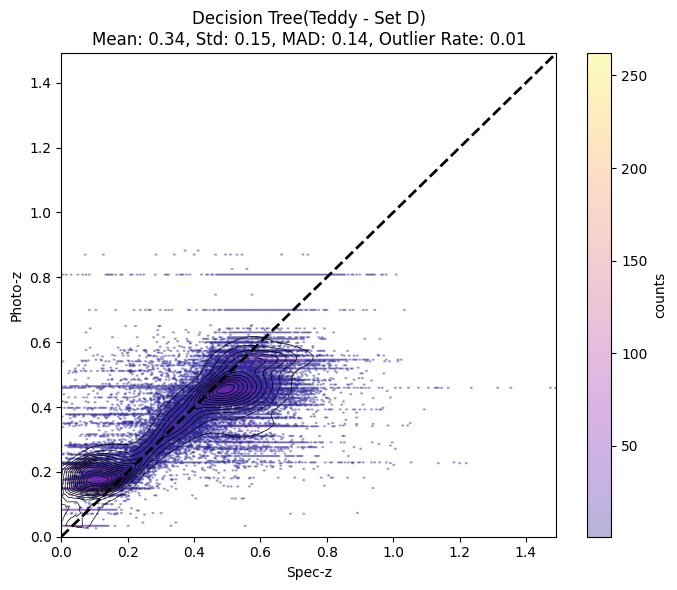

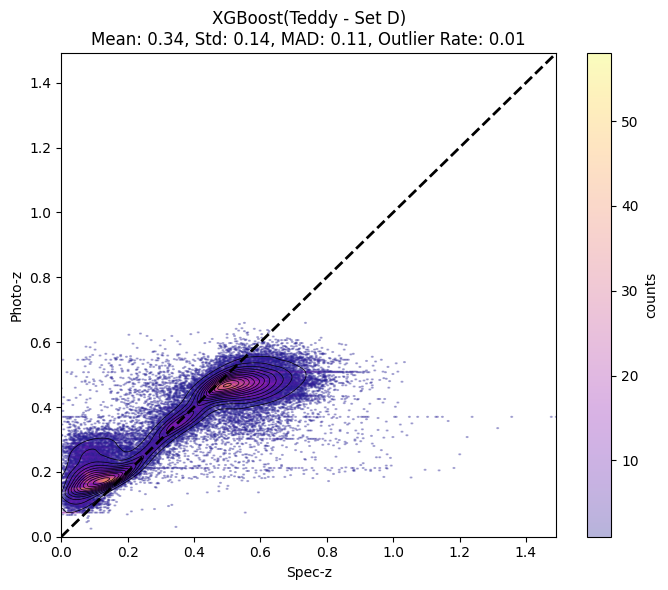

In [33]:
predictions_teddy_d = [y_pred_rf_teddy_d, y_pred_gb_teddy_d, y_pred_dt_teddy_d, y_pred_xgb_teddy_d]
labels_teddy_d = ['Random Forest(Teddy - Set D)', 'Gradient Boost(Teddy - Set D)', 'Decision Tree(Teddy - Set D)', 'XGBoost(Teddy - Set D)']
means_teddy_d = [mean_rf_teddy_d, mean_gb_teddy_d, mean_dt_teddy_d, mean_xgb_teddy_d]
stds_teddy_d = [std_rf_teddy_d, std_gb_teddy_d, std_dt_teddy_d, std_xgb_teddy_d]
mads_teddy_d = [mad_rf_teddy_d, mad_gb_teddy_d, mad_dt_teddy_d, mad_xgb_teddy_d]
outlier_rates_teddy_d = [outlier_rate_rf_teddy_d, outlier_rate_gb_teddy_d, outlier_rate_dt_teddy_d, outlier_rate_xgb_teddy_d]

visualize_results(y_test_teddy_d, predictions_teddy_d, labels_teddy_d, means_teddy_d, stds_teddy_d, mads_teddy_d, outlier_rates_teddy_d)

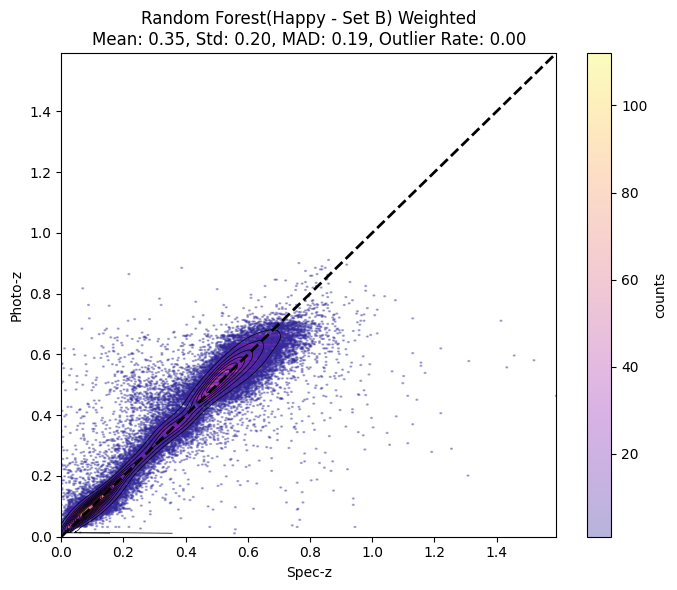

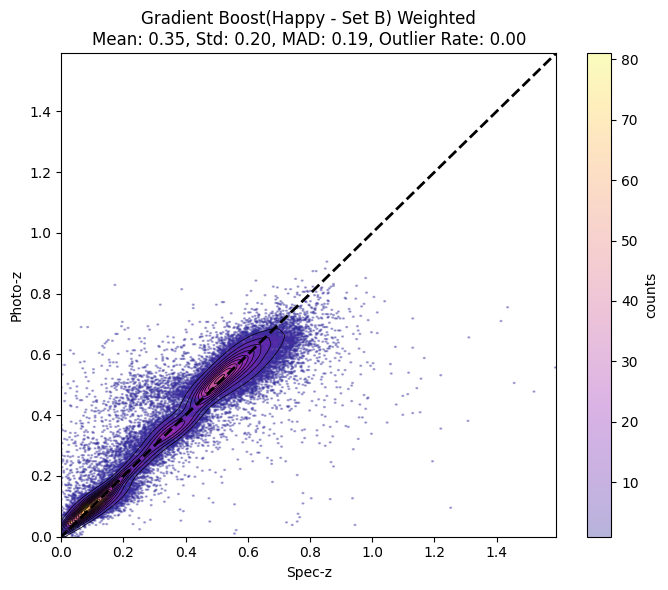

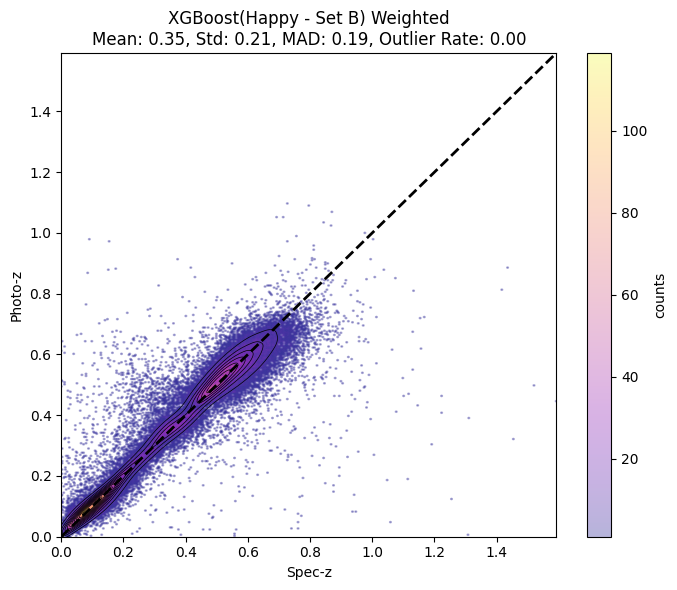

In [34]:
predictions_happy_b_w = [y_pred_rf_happy_b_w, y_pred_gb_happy_b_w, y_pred_xgb_happy_b_w]
labels_happy_b_w = ['Random Forest(Happy - Set B) Weighted', 'Gradient Boost(Happy - Set B) Weighted', 'XGBoost(Happy - Set B) Weighted']
means_happy_b_w = [mean_rf_happy_b_w, mean_gb_happy_b_w, mean_xgb_happy_b_w]
stds_happy_b_w = [std_rf_happy_b_w, std_gb_happy_b_w, std_xgb_happy_b_w]
mads_happy_b_w = [mad_rf_happy_b_w, mad_gb_happy_b_w, mad_xgb_happy_b_w]
outlier_rates_happy_b_w = [outlier_rate_rf_happy_b_w, outlier_rate_gb_happy_b_w, outlier_rate_xgb_happy_b_w]

visualize_results(y_test_happy_b, predictions_happy_b_w, labels_happy_b_w, means_happy_b_w, stds_happy_b_w, mads_happy_b_w, outlier_rates_happy_b_w)

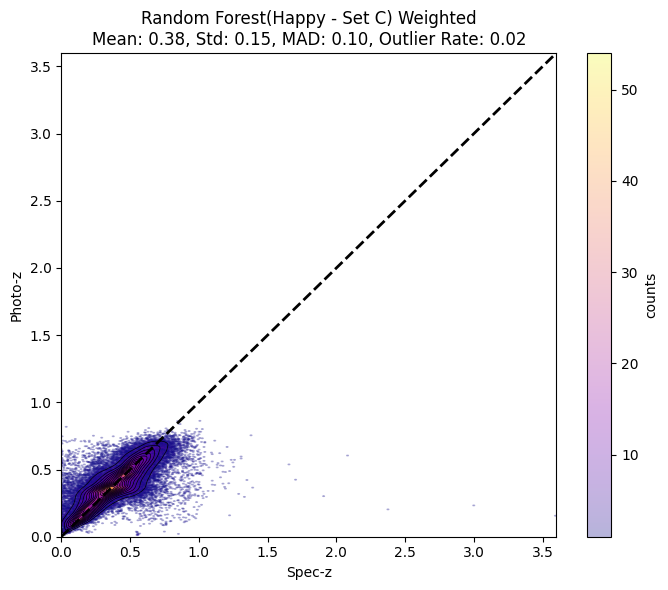

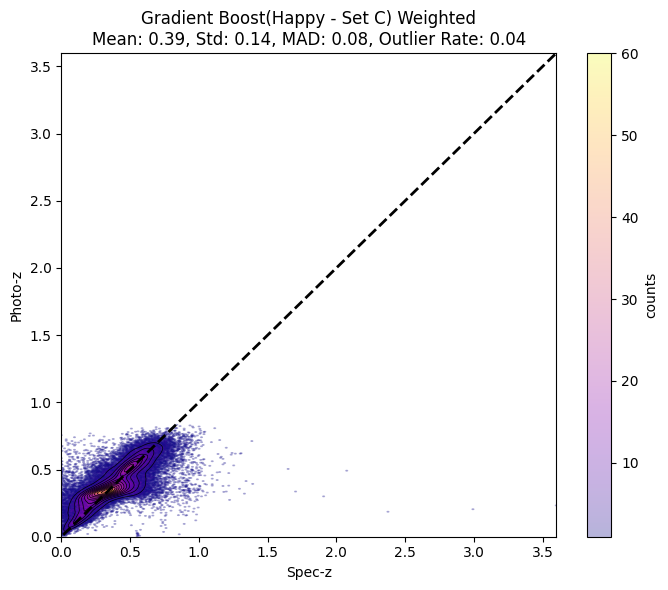

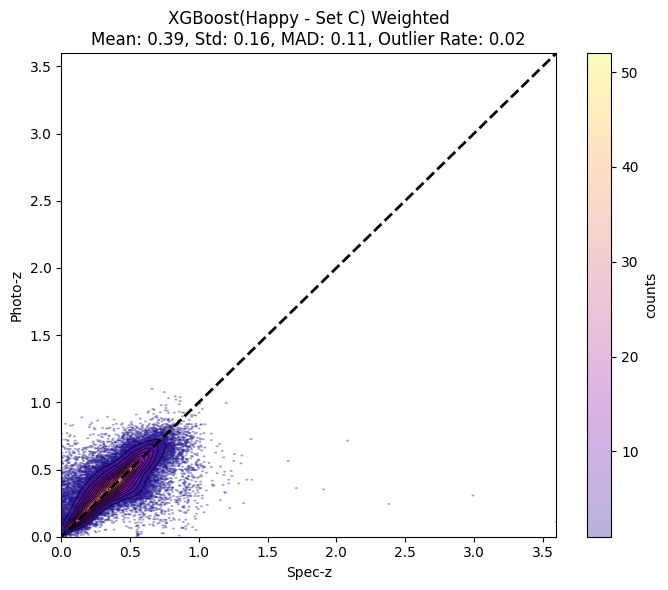

In [35]:
predictions_happy_c_w = [y_pred_rf_happy_c_w, y_pred_gb_happy_c_w, y_pred_xgb_happy_c_w]
labels_happy_c_w = ['Random Forest(Happy - Set C) Weighted', 'Gradient Boost(Happy - Set C) Weighted', 'XGBoost(Happy - Set C) Weighted']
means_happy_c_w = [mean_rf_happy_c_w, mean_gb_happy_c_w, mean_xgb_happy_c_w]
stds_happy_c_w = [std_rf_happy_c_w, std_gb_happy_c_w, std_xgb_happy_c_w]
mads_happy_c_w = [mad_rf_happy_c_w, mad_gb_happy_c_w, mad_xgb_happy_c_w]
outlier_rates_happy_c_w = [outlier_rate_rf_happy_c_w, outlier_rate_gb_happy_c_w, outlier_rate_xgb_happy_c_w]

visualize_results(y_test_happy_c, predictions_happy_c_w, labels_happy_c_w, means_happy_c_w, stds_happy_c_w, mads_happy_c_w, outlier_rates_happy_c_w)

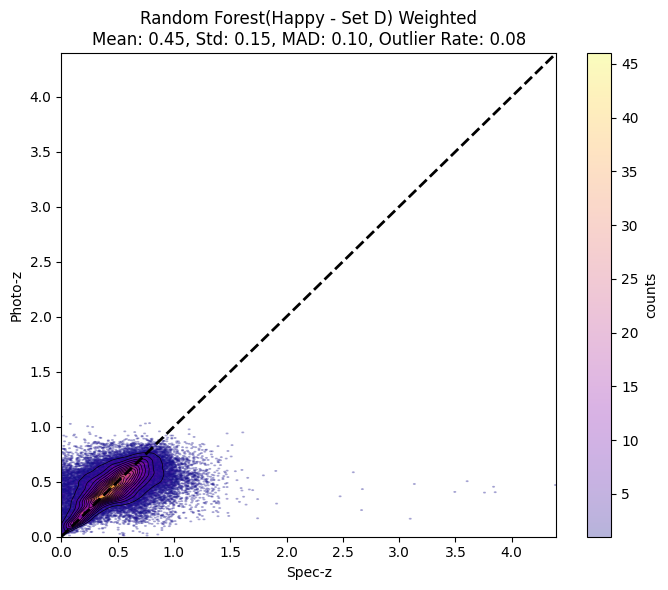

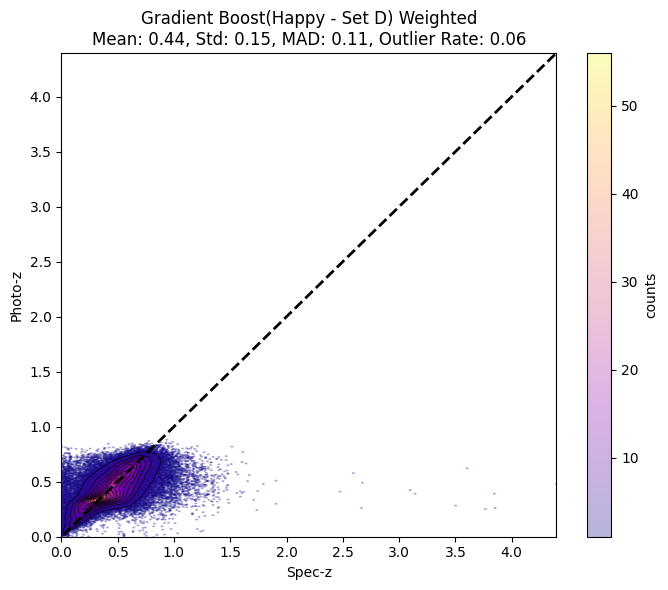

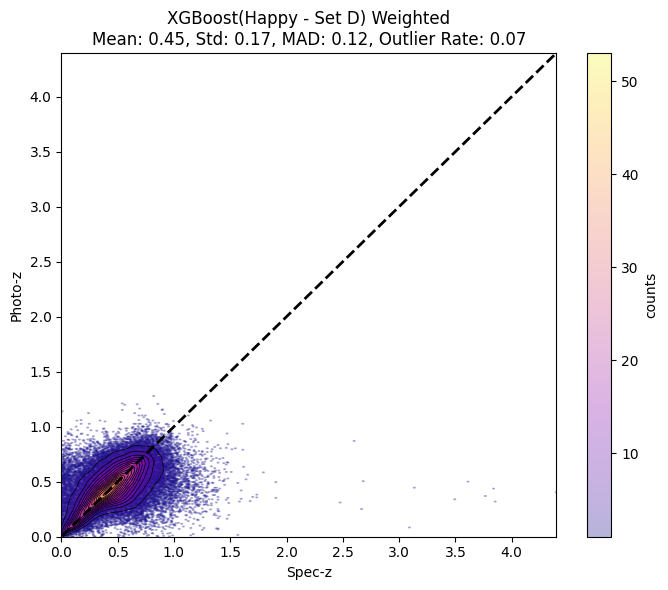

In [36]:
predictions_happy_d_w = [y_pred_rf_happy_d_w, y_pred_gb_happy_d_w, y_pred_xgb_happy_d_w]
labels_happy_d_w = ['Random Forest(Happy - Set D) Weighted', 'Gradient Boost(Happy - Set D) Weighted', 'XGBoost(Happy - Set D) Weighted']
means_happy_d_w = [mean_rf_happy_d_w, mean_gb_happy_d_w, mean_xgb_happy_d_w]
stds_happy_d_w = [std_rf_happy_d_w, std_gb_happy_d_w, std_xgb_happy_d_w]
mads_happy_d_w = [mad_rf_happy_d_w, mad_gb_happy_d_w, mad_xgb_happy_d_w]
outlier_rates_happy_d_w = [outlier_rate_rf_happy_d_w, outlier_rate_gb_happy_d_w, outlier_rate_xgb_happy_d_w]

visualize_results(y_test_happy_d, predictions_happy_d_w, labels_happy_d_w, means_happy_d_w, stds_happy_d_w, mads_happy_d_w, outlier_rates_happy_d_w)

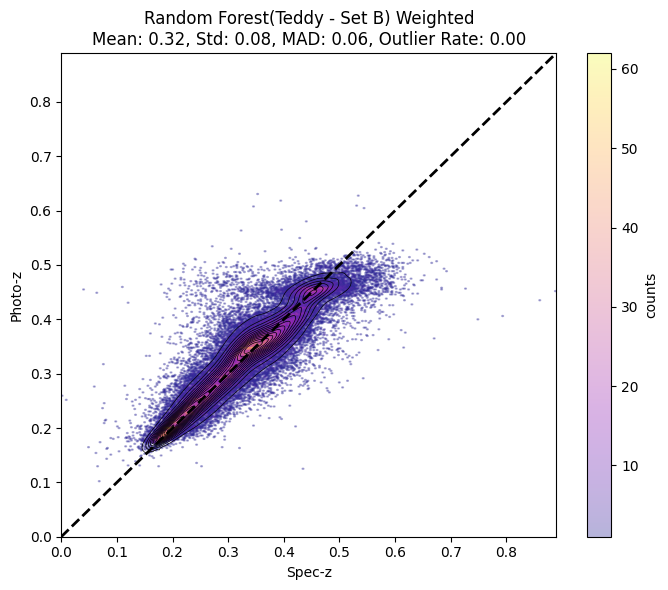

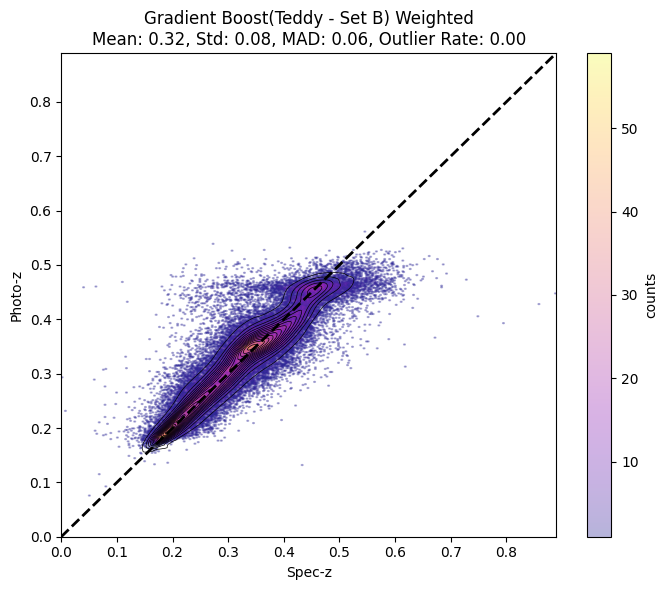

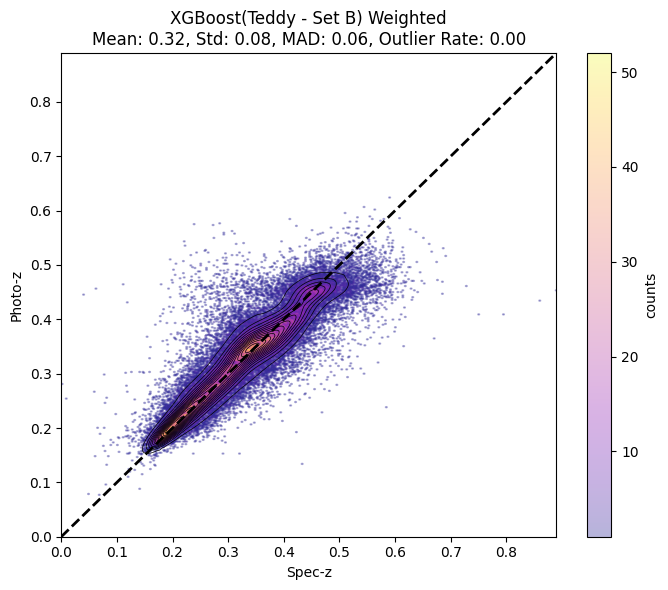

In [37]:
predictions_teddy_b_w = [y_pred_rf_teddy_b_w, y_pred_gb_teddy_b_w, y_pred_xgb_teddy_b_w]
labels_teddy_b_w = ['Random Forest(Teddy - Set B) Weighted', 'Gradient Boost(Teddy - Set B) Weighted','XGBoost(Teddy - Set B) Weighted']
means_teddy_b_w = [mean_rf_teddy_b_w, mean_gb_teddy_b_w, mean_xgb_teddy_b_w]
stds_teddy_b_w = [std_rf_teddy_b_w, std_gb_teddy_b_w, std_xgb_teddy_b_w]
mads_teddy_b_w = [mad_rf_teddy_b_w, mad_gb_teddy_b_w, mad_xgb_teddy_b_w]
outlier_rates_teddy_b_w = [outlier_rate_rf_teddy_b_w, outlier_rate_gb_teddy_b_w, outlier_rate_xgb_teddy_b_w]

visualize_results(y_test_teddy_b, predictions_teddy_b_w, labels_teddy_b_w, means_teddy_b_w, stds_teddy_b_w, mads_teddy_b_w, outlier_rates_teddy_b_w)


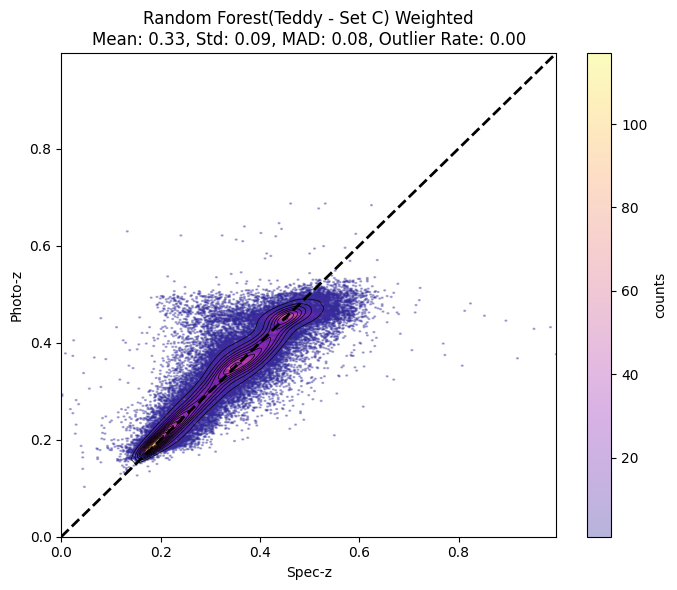

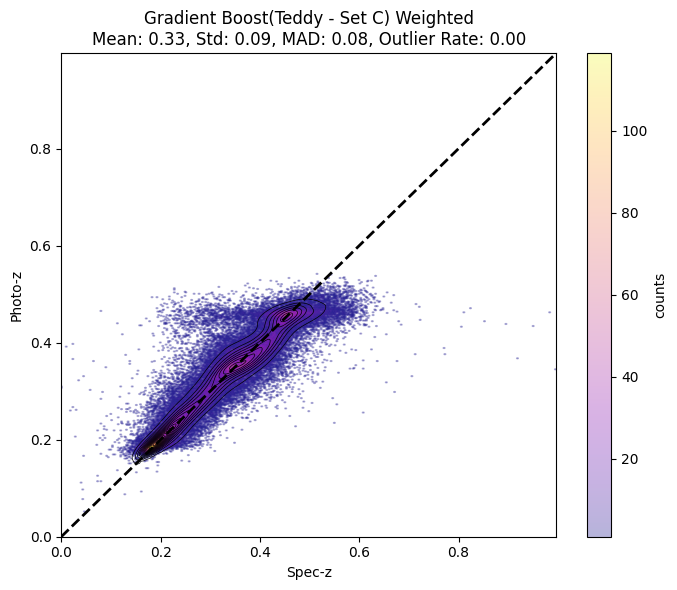

In [ ]:
predictions_teddy_c_w = [y_pred_rf_teddy_c_w, y_pred_gb_teddy_c_w, y_pred_xgb_teddy_c_w]
labels_teddy_c_w = ['Random Forest(Teddy - Set C) Weighted', 'Gradient Boost(Teddy - Set C) Weighted', 'XGBoost(Teddy - Set C) Weighted']
means_teddy_c_w = [mean_rf_teddy_c_w, mean_gb_teddy_c_w, mean_xgb_teddy_c_w]
stds_teddy_c_w = [std_rf_teddy_c_w, std_gb_teddy_c_w, std_xgb_teddy_c_w]
mads_teddy_c_w = [mad_rf_teddy_c_w, mad_gb_teddy_c_w, mad_xgb_teddy_c_w]
outlier_rates_teddy_c_w = [outlier_rate_rf_teddy_c_w, outlier_rate_gb_teddy_c_w, outlier_rate_xgb_teddy_c_w]

visualize_results(y_test_teddy_c, predictions_teddy_c_w, labels_teddy_c_w, means_teddy_c_w, stds_teddy_c_w, mads_teddy_c_w, outlier_rates_teddy_c_w)

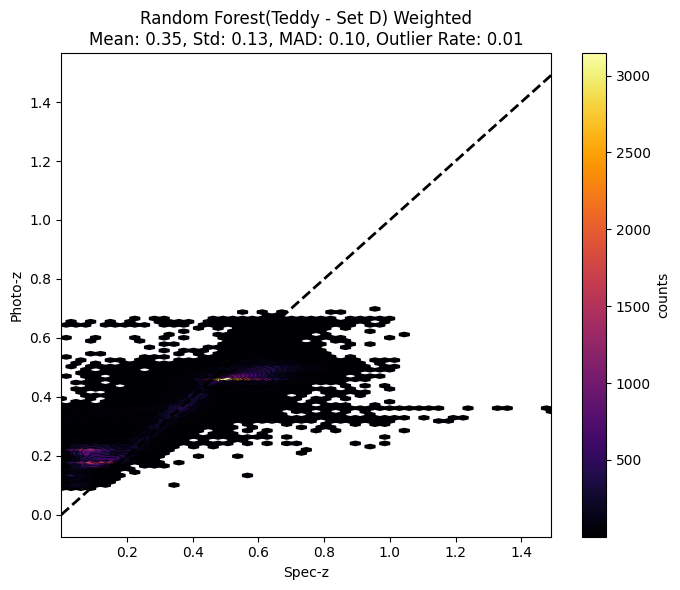

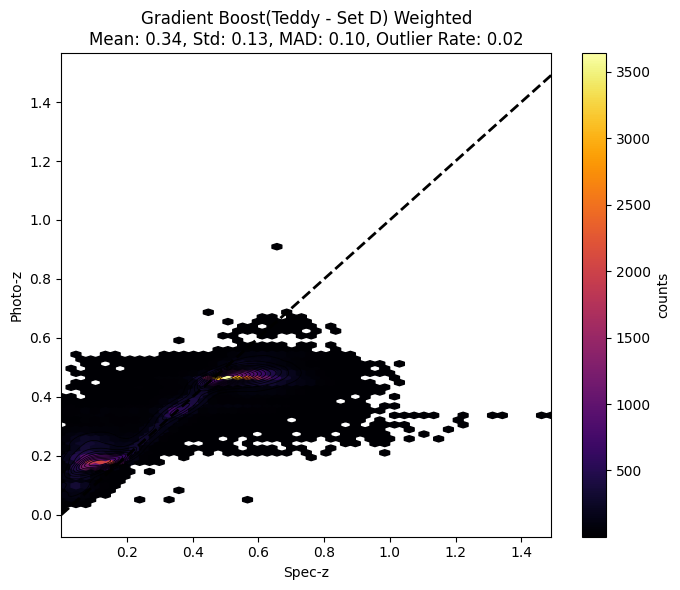

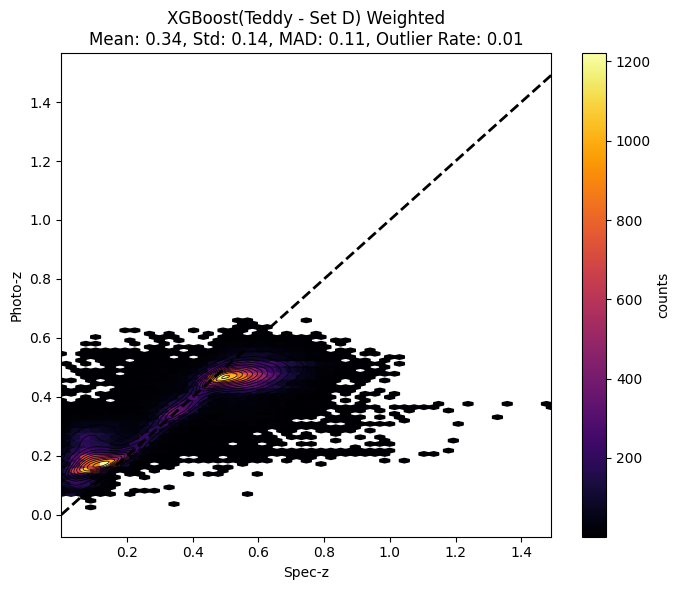

In [ ]:
predictions_teddy_d_w = [y_pred_rf_teddy_d_w, y_pred_gb_teddy_d_w, y_pred_xgb_teddy_d_w]
labels_teddy_d_w = ['Random Forest(Teddy - Set D) Weighted', 'Gradient Boost(Teddy - Set D) Weighted', 'XGBoost(Teddy - Set D) Weighted']
means_teddy_d_w = [mean_rf_teddy_d_w, mean_gb_teddy_d_w, mean_xgb_teddy_d_w]
stds_teddy_d_w = [std_rf_teddy_d_w, std_gb_teddy_d_w, std_xgb_teddy_d_w]
mads_teddy_d_w = [mad_rf_teddy_d_w, mad_gb_teddy_d_w, mad_xgb_teddy_d_w]
outlier_rates_teddy_d_w = [outlier_rate_rf_teddy_d_w, outlier_rate_gb_teddy_d_w, outlier_rate_xgb_teddy_d_w]

visualize_results(y_test_teddy_d, predictions_teddy_d_w, labels_teddy_d_w, means_teddy_d_w, stds_teddy_d_w, mads_teddy_d_w, outlier_rates_teddy_d_w)

In [ ]:
results = {'Dataset': [],
'Model': [],
'Mean': [],
'Std': [],
'MAD': [],
'Outlier Rate': []
}

def append_results(results, dataset, model, mean, std, mad, outlier_rate):
  results['Dataset'].append(dataset)
  results['Model'].append(model)
  results['Mean'].append(mean)
  results['Std'].append(std)
  results['MAD'].append(mad)
  results['Outlier Rate'].append(outlier_rate)

In [ ]:
# Append results for Happy Set B without weights
append_results(results, "Happy Set B", "Random Forest", mean_rf_happy_b, std_rf_happy_b, mad_rf_happy_b, outlier_rate_rf_happy_b)
append_results(results, "Happy Set B", "Gradient Boost", mean_gb_happy_b, std_gb_happy_b, mad_gb_happy_b, outlier_rate_gb_happy_b)
append_results(results, "Happy Set B", "Decision Tree", mean_dt_happy_b, std_dt_happy_b, mad_dt_happy_b, outlier_rate_dt_happy_b)
append_results(results, "Happy Set B", "XGBoost", mean_xgb_happy_b, std_xgb_happy_b, mad_xgb_happy_b, outlier_rate_xgb_happy_b)

# Append results for Happy Set B with weights
append_results(results, "Happy Set B w", "Random Forest", mean_rf_happy_b_w, std_rf_happy_b_w, mad_rf_happy_b_w, outlier_rate_rf_happy_b_w)
append_results(results, "Happy Set B w", "Gradient Boost", mean_gb_happy_b_w, std_gb_happy_b_w, mad_gb_happy_b_w, outlier_rate_gb_happy_b_w)
append_results(results, "Happy Set B w", "XGBoost", mean_xgb_happy_b_w, std_xgb_happy_b_w, mad_xgb_happy_b_w, outlier_rate_xgb_happy_b_w)

# Append results for Happy Set C without weights
append_results(results, "Happy Set C", "Random Forest", mean_rf_happy_c, std_rf_happy_c, mad_rf_happy_c, outlier_rate_rf_happy_c)
append_results(results, "Happy Set C", "Gradient Boost", mean_gb_happy_c, std_gb_happy_c, mad_gb_happy_c, outlier_rate_gb_happy_c)
append_results(results, "Happy Set C", "Decision Tree", mean_dt_happy_c, std_dt_happy_c, mad_dt_happy_c, outlier_rate_dt_happy_c)
append_results(results, "Happy Set C", "XGBoost", mean_xgb_happy_c, std_xgb_happy_c, mad_xgb_happy_c, outlier_rate_xgb_happy_c)

# Append results for Happy Set C with weights
append_results(results, "Happy Set C w", "Random Forest", mean_rf_happy_c_w, std_rf_happy_c_w, mad_rf_happy_c_w, outlier_rate_rf_happy_c_w)
append_results(results, "Happy Set C w", "Gradient Boost", mean_gb_happy_c_w, std_gb_happy_c_w, mad_gb_happy_c_w, outlier_rate_gb_happy_c_w)
append_results(results, "Happy Set C w", "XGBoost", mean_xgb_happy_c_w, std_xgb_happy_c_w, mad_xgb_happy_c_w, outlier_rate_xgb_happy_c_w)

# Append results for Happy Set D without weights
append_results(results, "Happy Set D", "Random Forest", mean_rf_happy_d, std_rf_happy_d, mad_rf_happy_d, outlier_rate_rf_happy_d)
append_results(results, "Happy Set D", "Gradient Boost", mean_gb_happy_d, std_gb_happy_d, mad_gb_happy_d, outlier_rate_gb_happy_d)
append_results(results, "Happy Set D", "Decision Tree", mean_dt_happy_d, std_dt_happy_d, mad_dt_happy_d, outlier_rate_dt_happy_d)
append_results(results, "Happy Set D", "XGBoost", mean_xgb_happy_d, std_xgb_happy_d, mad_xgb_happy_d, outlier_rate_xgb_happy_d)

# Append results for Happy Set D with weights
append_results(results, "Happy Set D w", "Random Forest", mean_rf_happy_d_w, std_rf_happy_d_w, mad_rf_happy_d_w, outlier_rate_rf_happy_d_w)
append_results(results, "Happy Set D w", "Gradient Boost", mean_gb_happy_d_w, std_gb_happy_d_w, mad_gb_happy_d_w, outlier_rate_gb_happy_d_w)
append_results(results, "Happy Set D w", "XGBoost", mean_xgb_happy_d_w, std_xgb_happy_d_w, mad_xgb_happy_d_w, outlier_rate_xgb_happy_d_w)

# Append results for Teddy Set B without weights
append_results(results, "Teddy Set B", "Random Forest", mean_rf_teddy_b, std_rf_teddy_b, mad_rf_teddy_b, outlier_rate_rf_teddy_b)
append_results(results, "Teddy Set B", "Gradient Boost", mean_gb_teddy_b, std_gb_teddy_b, mad_gb_teddy_b, outlier_rate_gb_teddy_b)
append_results(results, "Teddy Set B", "Decision Tree", mean_dt_teddy_b, std_dt_teddy_b, mad_dt_teddy_b, outlier_rate_dt_teddy_b)
append_results(results, "Teddy Set B", "XGBoost", mean_xgb_teddy_b, std_xgb_teddy_b, mad_xgb_teddy_b, outlier_rate_xgb_teddy_b)

# Append results for Teddy Set B with weights
append_results(results, "Teddy Set B w", "Random Forest", mean_rf_teddy_b_w, std_rf_teddy_b_w, mad_rf_teddy_b_w, outlier_rate_rf_teddy_b_w)
append_results(results, "Teddy Set B w", "Gradient Boost", mean_gb_teddy_b_w, std_gb_teddy_b_w, mad_gb_teddy_b_w, outlier_rate_gb_teddy_b_w)
append_results(results, "Teddy Set B w", "XGBoost", mean_xgb_teddy_b_w, std_xgb_teddy_b_w, mad_xgb_teddy_b_w, outlier_rate_xgb_teddy_b_w)

# Append results for Teddy Set C without weights
append_results(results, "Teddy Set C", "Random Forest", mean_rf_teddy_c, std_rf_teddy_c, mad_rf_teddy_c, outlier_rate_rf_teddy_c)
append_results(results, "Teddy Set C", "Gradient Boost", mean_gb_teddy_c, std_gb_teddy_c, mad_gb_teddy_c, outlier_rate_gb_teddy_c)
append_results(results, "Teddy Set C", "Decision Tree", mean_dt_teddy_c, std_dt_teddy_c, mad_dt_teddy_c, outlier_rate_dt_teddy_c)
append_results(results, "Teddy Set C", "XGBoost", mean_xgb_teddy_c, std_xgb_teddy_c, mad_xgb_teddy_c, outlier_rate_xgb_teddy_c)

# Append results for Teddy Set C with weights
append_results(results, "Teddy Set C w", "Random Forest", mean_rf_teddy_c_w, std_rf_teddy_c_w, mad_rf_teddy_c_w, outlier_rate_rf_teddy_c_w)
append_results(results, "Teddy Set C w", "Gradient Boost", mean_gb_teddy_c_w, std_gb_teddy_c_w, mad_gb_teddy_c_w, outlier_rate_gb_teddy_c_w)
append_results(results, "Teddy Set C w", "XGBoost", mean_xgb_teddy_c_w, std_xgb_teddy_c_w, mad_xgb_teddy_c_w, outlier_rate_xgb_teddy_c_w)

# Append results for Teddy Set D without weights
append_results(results, "Teddy Set D", "Random Forest", mean_rf_teddy_d, std_rf_teddy_d, mad_rf_teddy_d, outlier_rate_rf_teddy_d)
append_results(results, "Teddy Set D", "Gradient Boost", mean_gb_teddy_d, std_gb_teddy_d, mad_gb_teddy_d, outlier_rate_gb_teddy_d)
append_results(results, "Teddy Set D", "Decision Tree", mean_dt_teddy_d, std_dt_teddy_d, mad_dt_teddy_d, outlier_rate_dt_teddy_d)
append_results(results, "Teddy Set D", "XGBoost", mean_xgb_teddy_d, std_xgb_teddy_d, mad_xgb_teddy_d, outlier_rate_xgb_teddy_d)

# Append results for Teddy Set D with weights
append_results(results, "Teddy Set D", "Random Forest", mean_rf_teddy_d_w, std_rf_teddy_d_w, mad_rf_teddy_d_w, outlier_rate_rf_teddy_d_w)
append_results(results, "Teddy Set D", "Gradient Boost", mean_gb_teddy_d_w, std_gb_teddy_d_w, mad_gb_teddy_d_w, outlier_rate_gb_teddy_d)
append_results(results, "Teddy Set D", "XGBoost", mean_xgb_teddy_d_w, std_xgb_teddy_d_w, mad_xgb_teddy_d_w, outlier_rate_xgb_teddy_d)


results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv('/content/drive/MyDrive/GalaxyProject/results_summary.csv', index=False)
print('Results saved to CSV file.')

          Dataset           Model      Mean       Std       MAD  Outlier Rate
0     Happy Set B   Random Forest  0.351605  0.204378  0.185806      0.000814
1     Happy Set B  Gradient Boost  0.351708  0.202979  0.187309      0.000628
2     Happy Set B   Decision Tree  0.352184  0.212557  0.191932      0.001923
3     Happy Set B         XGBoost  0.351618  0.205855  0.186881      0.000854
4   Happy Set B w   Random Forest  0.351605  0.204378  0.185806      0.000814
5   Happy Set B w  Gradient Boost  0.351706  0.202980  0.187314      0.000628
6   Happy Set B w         XGBoost  0.351618  0.205855  0.186881      0.000854
7     Teddy Set B   Random Forest  0.323062  0.081319  0.060844      0.002589
8     Teddy Set B  Gradient Boost  0.323074  0.080905  0.059242      0.002937
9     Teddy Set B   Decision Tree  0.323058  0.088076  0.066116      0.006827
10    Teddy Set B         XGBoost  0.323050  0.081878  0.061219      0.002897
11  Teddy Set B w   Random Forest  0.323062  0.081319  0.060844 

In [ ]:


# Function to calculate error bars and plot
def plot_error_bars(y_true, y_pred, model_name, n_bins=50):
    # Calculate the difference between true and predicted values
    delta_z = y_pred - y_true

    # Create a dataframe for easy manipulation
    df = pd.DataFrame({'z_spec': y_true, 'delta_z': delta_z})

    # Bin the data
    df['bin'] = pd.qcut(df['z_spec'], q=n_bins, labels=False)

    # Calculate mean and standard error for each bin
    bin_means = df.groupby('bin')['z_spec'].mean()
    bin_deltas = df.groupby('bin')['delta_z'].mean()
    bin_errors = df.groupby('bin')['delta_z'].std() / np.sqrt(df.groupby('bin').size())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_means, bin_deltas, yerr=bin_errors, fmt='r+', ecolor='black', capsize=5)
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(y=np.std(delta_z), color='gray', linestyle=':')
    plt.axhline(y=-np.std(delta_z), color='gray', linestyle=':')
    plt.xlabel('Spectroscopic Redshift, $z_{spec}$')
    plt.ylabel(r'$\Delta z = z_{phot} - z_{spec}$')
    plt.title(f'{model_name}\n$\Delta z$ vs $z_{spec}$ with Error Bars')
    plt.show()



# Example usage for Happy - Set B Weighted
plot_error_bars(y_test_happy_b, y_pred_rf_happy_b_w, 'Random Forest (Happy - Set B) Weighted')
plot_error_bars(y_test_happy_b, y_pred_gb_happy_b_w, 'Gradient Boost (Happy - Set B) Weighted')
plot_error_bars(y_test_happy_b, y_pred_xgb_happy_b_w, 'XGBoost (Happy - Set B) Weighted')

# Example usage for Teddy - Set B Weighted
plot_error_bars(y_test_teddy_b, y_pred_rf_teddy_b_w, 'Random Forest (Teddy - Set B) Weighted')
plot_error_bars(y_test_teddy_b, y_pred_gb_teddy_b_w, 'Gradient Boost (Teddy - Set B) Weighted')
plot_error_bars(y_test_teddy_b, y_pred_xgb_teddy_b_w, 'XGBoost (Teddy - Set B) Weighted')


NameError: name 'y_test_happy_b' is not defined